In [79]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F
import torch.optim

import math
import time
import os
import random

import sys
sys.path.insert(0,'..')

## Compare DIP, VF, and Interp
import skimage.metrics
from skimage.metrics import peak_signal_noise_ratio as psnr

In [80]:
device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:5


# 1. Load the data and get measurements

In [81]:
ROOT_PATH = "/scratch/cluster/bodeng/UTAFSDataNew/new_data"
CHIP_NUM = 20

In [82]:
import utils

data_dict = utils.grab_chip_data(ROOT_PATH, CHIP_NUM)

In [83]:
data_dict.keys()

dict_keys(['gt_matrix', 'gt_freqs', 'vf_matrix', 'y_matrix', 'y_freqs'])

## Convert the raw data matrices to only the unique S-parameters

In [84]:
vf_data = utils.matrix_to_sparams(data_dict['vf_matrix'])
gt_data = utils.matrix_to_sparams(data_dict['gt_matrix'])
y_data = utils.matrix_to_sparams(data_dict['y_matrix'])

print("VF S-parameters shape: ", vf_data.shape)
print("GT S-parameters shape: ", gt_data.shape)
print("Y S-parameters shape: ", y_data.shape)

VF S-parameters shape:  (3, 2, 1500)
GT S-parameters shape:  (3, 2, 1500)
Y S-parameters shape:  (3, 2, 62)


In [85]:
gt_freqs = data_dict['gt_freqs']
y_freqs = data_dict['y_freqs']

print("GT frequencies shape: ", gt_freqs.shape)
print("Y frequencies shape: ", y_freqs.shape)

GT frequencies shape:  (1500,)
Y frequencies shape:  (62,)


In [86]:
import scipy as sp

spacings = gt_freqs[1:] - gt_freqs[:-1]

mode_spacing = sp.stats.mode(spacings, keepdims=False)[0]
num_mode = len(np.where(spacings==mode_spacing)[0])

print("First frequency point: ", gt_freqs[0])
print("Mean frequency spacing: ", np.mean(spacings))
print("STD frequency spacing: ", np.std(spacings))
print("Mode frequency spacing: ", mode_spacing)
print("Number of samples with non-equal spacing: ", len(gt_freqs) - num_mode)

First frequency point:  100000000.0
Mean frequency spacing:  100000000.0
STD frequency spacing:  4.416102007326934e-06
Mode frequency spacing:  100000000.0
Number of samples with non-equal spacing:  126


In [87]:
#NOTE THIS IS EXPERIMENTAL!!!
if gt_freqs[0] == 0:
    gt_freqs = gt_freqs[1:]
    gt_data = gt_data[:, :, 1:]

## Make some variables we will need

In [88]:
N_FREQS = gt_data.shape[-1]
N_SPARAMS = gt_data.shape[0]  

print("N_FREQS: ", N_FREQS)
print("N_SPARAMS: ", N_SPARAMS)

N_FREQS:  1500
N_SPARAMS:  3


In [89]:
x = torch.from_numpy(gt_data).view(-1, N_FREQS).unsqueeze(0).to(device)

print("x shape: ", x.shape)

x shape:  torch.Size([1, 6, 1500])


In [90]:
x_mag = utils.sparams_to_mag(x)

print("x_mag shape: ", x_mag.shape)

x_mag shape:  torch.Size([1, 3, 1500])


## Plot some stuff

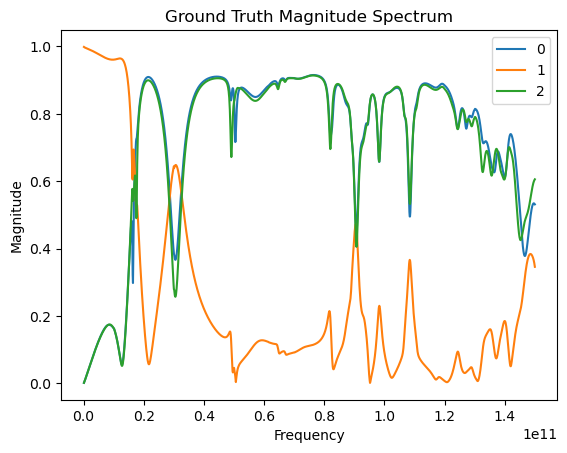

In [91]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x_mag[0, i].cpu(), label=str(i))
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Magnitude Spectrum")
plt.ylabel("Magnitude")
plt.xlabel("Frequency")
plt.show()

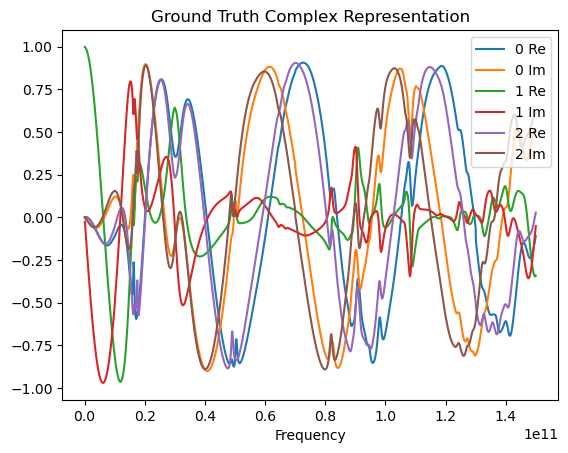

In [92]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" Re")
    plt.plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" Im")
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Complex Representation")
plt.xlabel("Frequency")
plt.show()

## Grab Some Measurements

In [93]:
PROBLEM_TYPE = "equal" #[random, equal, forecast, full, log, sqrt]
# M = int(0.10 * N_FREQS)
M = 62

kept_inds, missing_inds = utils.get_inds(PROBLEM_TYPE, N_FREQS, M)
old_kept = kept_inds.copy()

M = len(kept_inds) #re-define in case kept_inds is off by 1 or something

# remove every other point, starting at the back, don't remove first point
remove = False
for i in range(len(kept_inds) - 1, 0, -1):
    if remove:
        kept_inds = np.delete(kept_inds, [i])
        remove = False
    else:
        remove = True


print("Number of Ground Truth Frequency Points: ", N_FREQS)
print("Number of Measurements: ", M)
print("Undersampling Ratio: ", M/N_FREQS)
print(kept_inds)
print(old_kept)

Number of Ground Truth Frequency Points:  1500
Number of Measurements:  62
Undersampling Ratio:  0.04133333333333333
[   0   24   73  122  172  221  270  319  368  417  466  516  565  614
  663  712  761  810  860  909  958 1007 1056 1105 1154 1204 1253 1302
 1351 1400 1449 1499]
[   0   24   49   73   98  122  147  172  196  221  245  270  294  319
  344  368  393  417  442  466  491  516  540  565  589  614  638  663
  688  712  737  761  786  810  835  860  884  909  933  958  982 1007
 1032 1056 1081 1105 1130 1154 1179 1204 1228 1253 1277 1302 1326 1351
 1376 1400 1425 1449 1474 1499]


In [94]:
y = torch.clone(x)[:, :, kept_inds]
y_freqs = gt_freqs[kept_inds]

print("y shape: ", y.shape)
print("y_freqs shape: ", y_freqs.shape)

y shape:  torch.Size([1, 6, 32])
y_freqs shape:  (32,)


# 2. Network Setup

## Define network parameters

In [95]:
NZ = y.shape[1]

NUM_LAYERS = int(np.ceil(np.log2(N_FREQS))) - 4

if NZ < 64:
    BASE_NGF = 2 ** (int(np.ceil(np.log2(NZ))) + 1) #second power of two after NZ 
elif NZ < 128:
    BASE_NGF = 2 ** int(np.ceil(np.log2(NZ))) #next highest power of 2
else:
    BASE_NGF = NZ

NGF = [BASE_NGF] * NUM_LAYERS

BS = y.shape[0]
NC = y.shape[1]

KERNEL_SIZE = 3
USE_SKIP = False
CAUSAL_PASSIVE = True
OPTIMIZE_Z = False
USE_SGLD = False

In [96]:
print("NZ: ", str(NZ))
print("NUM_LAYERS: ", str(NUM_LAYERS))
print("BASE NGF: ", str(BASE_NGF))
print("NGF: ", str(NGF))
print("BS: ", BS)
print("NC: ", NC)
print("KERNEL_SIZE: ", KERNEL_SIZE)
print("USE_SKIP: ", USE_SKIP)
print("CAUSAL_PASSIVE: ", CAUSAL_PASSIVE)
print("OPTIMIZE_Z: ", OPTIMIZE_Z)

NZ:  6
NUM_LAYERS:  7
BASE NGF:  16
NGF:  [16, 16, 16, 16, 16, 16, 16]
BS:  1
NC:  6
KERNEL_SIZE:  3
USE_SKIP:  False
CAUSAL_PASSIVE:  True
OPTIMIZE_Z:  False


## Init and check dimensions

In [97]:
from models import RES_UNET

ENSEMBLE_SIZE = 5

ensemble = [RES_UNET(bs=BS,
               nz=NZ,
               ngf=NGF,
               output_size=N_FREQS,
               nc=NC,
               optimize_z=OPTIMIZE_Z,
               kernel_size=KERNEL_SIZE,
               num_layers=NUM_LAYERS,
               use_skip=USE_SKIP,
               causal_passive=CAUSAL_PASSIVE,
               p_dropout=0.0
               ) for i in range(ENSEMBLE_SIZE)]
for net in ensemble:
    net = net.to(device)

# Choose one network to visualize the results
net = ensemble[ENSEMBLE_SIZE // 2]

In [98]:
test_out = net.forward_with_z()

print("Net output shape: ", test_out.shape)

Net output shape:  torch.Size([1, 6, 1500])


In [99]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("TOTAL PARAMS: ", pytorch_total_params)

TOTAL PARAMS:  26002


# 3. Run

In [100]:
def find_max_variance(outputs, pickRandom=False):
    # Outputs of shape [ENSEMBLE_SIZE, 20, 1000]
    print("each output: ", outputs[0].shape)

    # Call np.var with dim = 0 to get shape [20, 1000]
    stacked_output = torch.cat(outputs, dim=0)
    print("after cat: ", stacked_output.shape)

    var_output = torch.var(stacked_output, dim=0)
    print("after var: ", var_output.shape)

    # Sum to go to [1000]
    var_output = torch.sum(var_output, dim=0)

    print("after sum: ", var_output.shape)

    if pickRandom:
        while True:
            rand_idx = random.randint(0, len(var_output) - 1)
            if rand_idx not in kept_inds:
                print("picked: ", rand_idx)
                return rand_idx

    _, idxs = torch.topk(var_output, len(var_output))

    for idx in idxs:
        if idx.item() not in kept_inds:
            return idx.item()
    return -1

## Define training parameters, losses, and track stats

NUM ACTIVE:  30
NUM ACTIVELY SAMPLED:  0
DIP PSNR:  32.55159190317763
DIP MSE:  0.002222802024334669


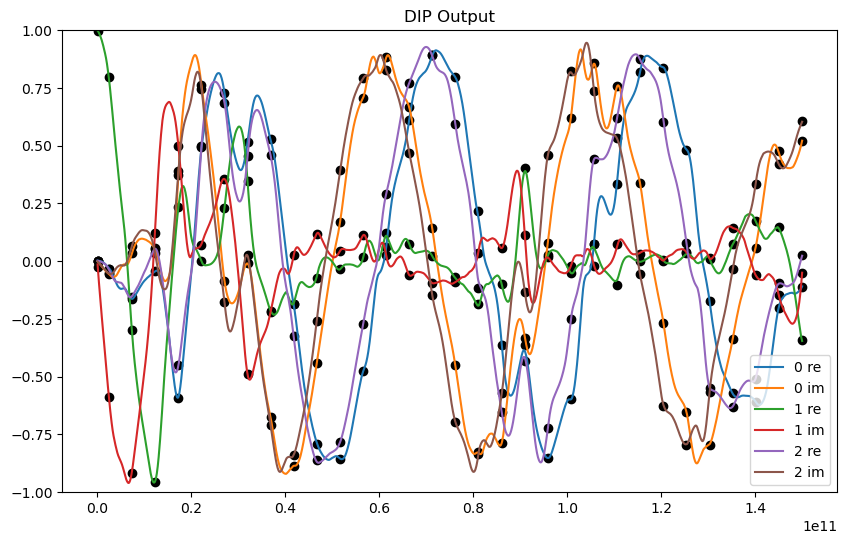

each output:  torch.Size([1, 6, 1500])
after cat:  torch.Size([5, 6, 1500])
after var:  torch.Size([6, 1500])
after sum:  torch.Size([1500])
[   0   24   73  122  172  221  270  319  368  417  466  516  565  614
  663  712  761  810  831  860  909  958 1007 1056 1105 1154 1204 1253
 1302 1351 1400 1449 1499]
NUM ACTIVELY SAMPLED:  1
DIP PSNR:  32.89483954413064
DIP MSE:  0.0020538847893476486


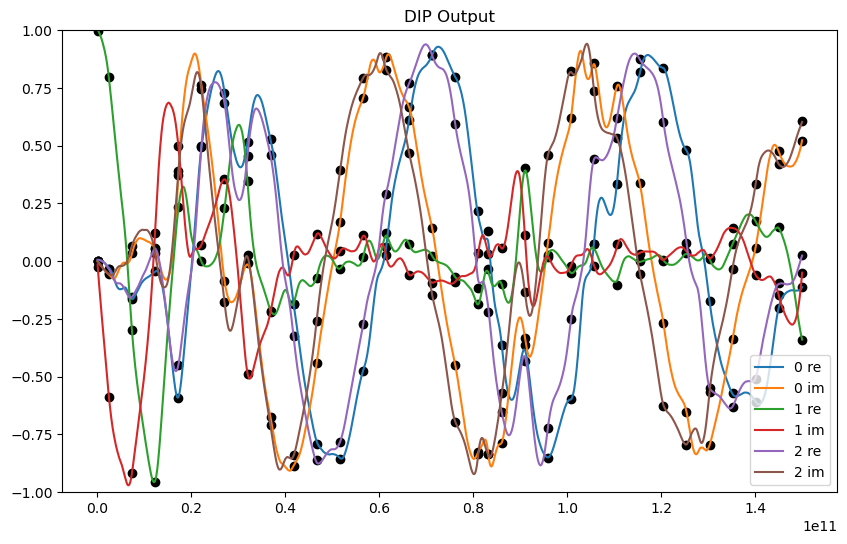

each output:  torch.Size([1, 6, 1500])
after cat:  torch.Size([5, 6, 1500])
after var:  torch.Size([6, 1500])
after sum:  torch.Size([1500])
[   0   24   73  122  172  221  270  319  368  417  466  516  565  614
  663  712  761  794  810  831  860  909  958 1007 1056 1105 1154 1204
 1253 1302 1351 1400 1449 1499]
NUM ACTIVELY SAMPLED:  2
DIP PSNR:  33.078453754606485
DIP MSE:  0.0019688589964061975


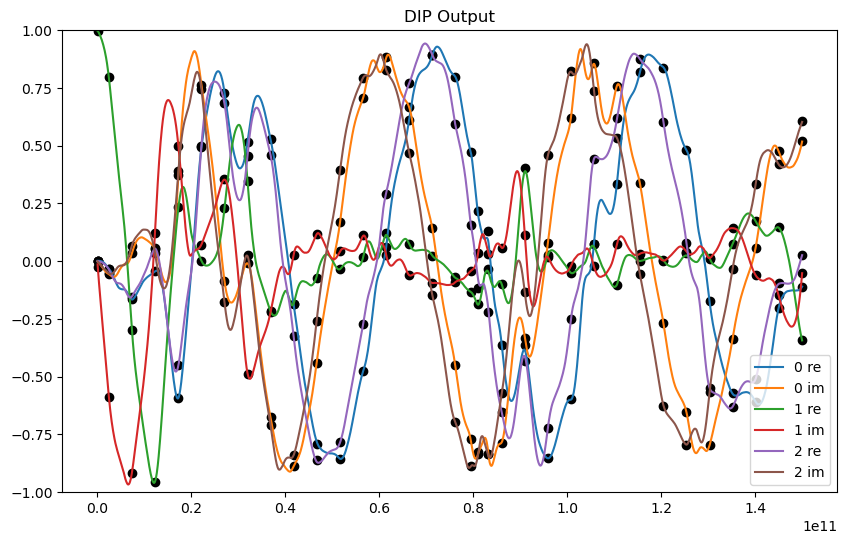

each output:  torch.Size([1, 6, 1500])
after cat:  torch.Size([5, 6, 1500])
after var:  torch.Size([6, 1500])
after sum:  torch.Size([1500])
[   0   24   73  122  172  221  270  319  368  417  466  516  565  614
  663  712  761  794  810  831  860  909  958 1007 1034 1056 1105 1154
 1204 1253 1302 1351 1400 1449 1499]
NUM ACTIVELY SAMPLED:  3
DIP PSNR:  33.70454851269221
DIP MSE:  0.001704531954601407


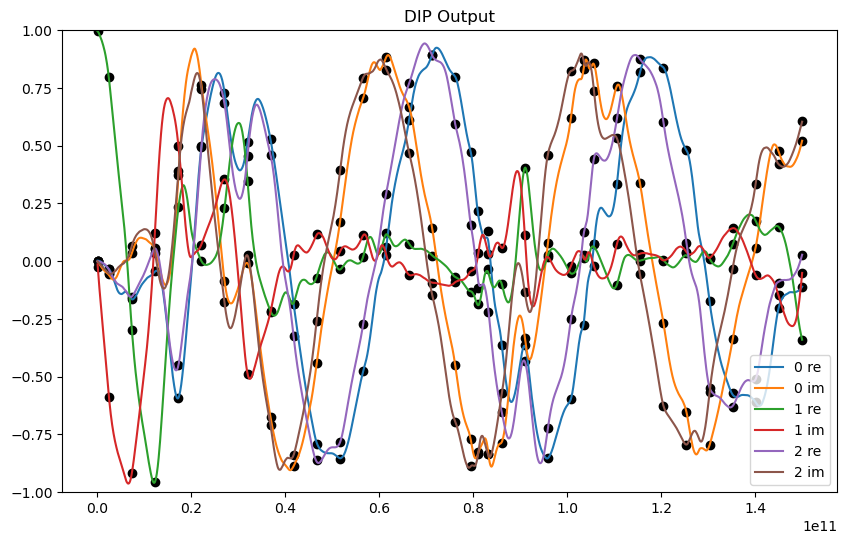

each output:  torch.Size([1, 6, 1500])
after cat:  torch.Size([5, 6, 1500])
after var:  torch.Size([6, 1500])
after sum:  torch.Size([1500])
[   0   24   73  122  172  221  270  319  368  395  417  466  516  565
  614  663  712  761  794  810  831  860  909  958 1007 1034 1056 1105
 1154 1204 1253 1302 1351 1400 1449 1499]
NUM ACTIVELY SAMPLED:  4
DIP PSNR:  33.76650753268385
DIP MSE:  0.0016803867183625698


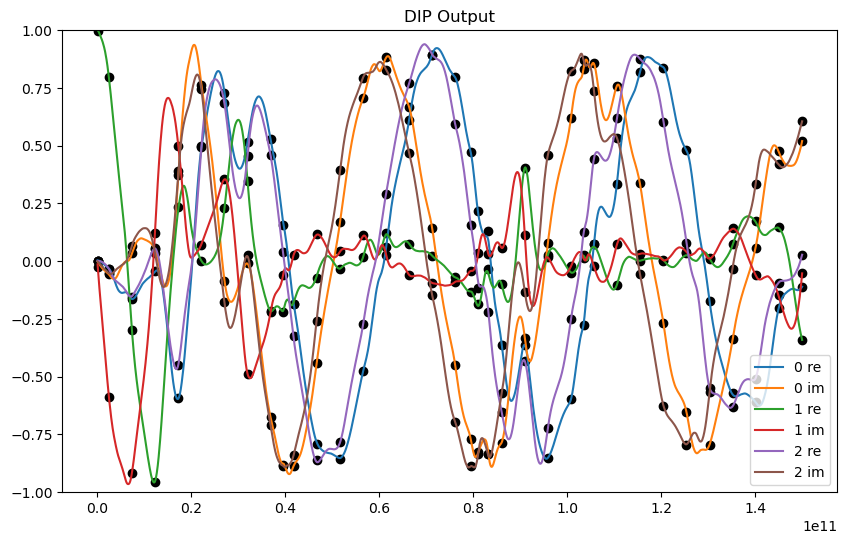

each output:  torch.Size([1, 6, 1500])
after cat:  torch.Size([5, 6, 1500])
after var:  torch.Size([6, 1500])
after sum:  torch.Size([1500])
[   0   24   73  122  172  199  221  270  319  368  395  417  466  516
  565  614  663  712  761  794  810  831  860  909  958 1007 1034 1056
 1105 1154 1204 1253 1302 1351 1400 1449 1499]
NUM ACTIVELY SAMPLED:  5
DIP PSNR:  34.152615930024254
DIP MSE:  0.0015374408103525639


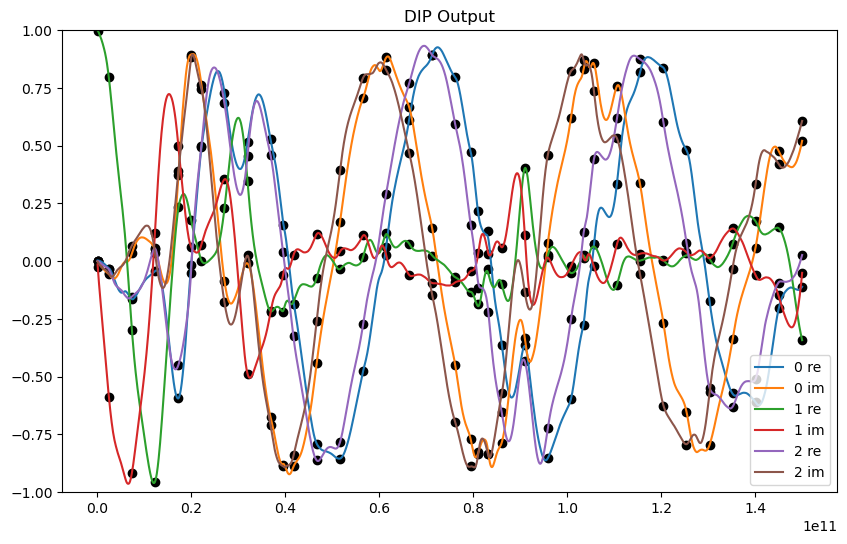

each output:  torch.Size([1, 6, 1500])
after cat:  torch.Size([5, 6, 1500])
after var:  torch.Size([6, 1500])
after sum:  torch.Size([1500])
[   0   24   73  122  172  199  221  270  319  368  395  417  466  516
  565  591  614  663  712  761  794  810  831  860  909  958 1007 1034
 1056 1105 1154 1204 1253 1302 1351 1400 1449 1499]
NUM ACTIVELY SAMPLED:  6
DIP PSNR:  34.22405178070013
DIP MSE:  0.0015123587800189853


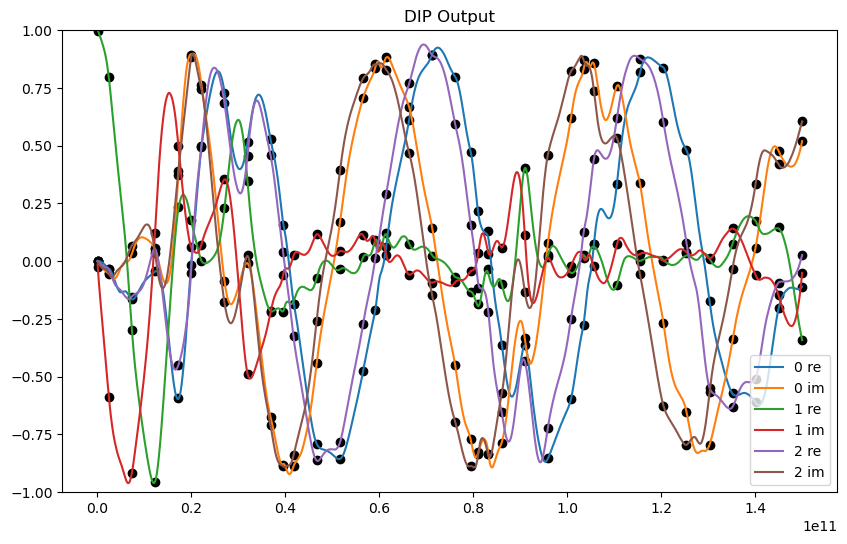

each output:  torch.Size([1, 6, 1500])
after cat:  torch.Size([5, 6, 1500])
after var:  torch.Size([6, 1500])
after sum:  torch.Size([1500])
[   0   24   73  122  149  172  199  221  270  319  368  395  417  466
  516  565  591  614  663  712  761  794  810  831  860  909  958 1007
 1034 1056 1105 1154 1204 1253 1302 1351 1400 1449 1499]
NUM ACTIVELY SAMPLED:  7
DIP PSNR:  34.61620438800879
DIP MSE:  0.001381782116368413


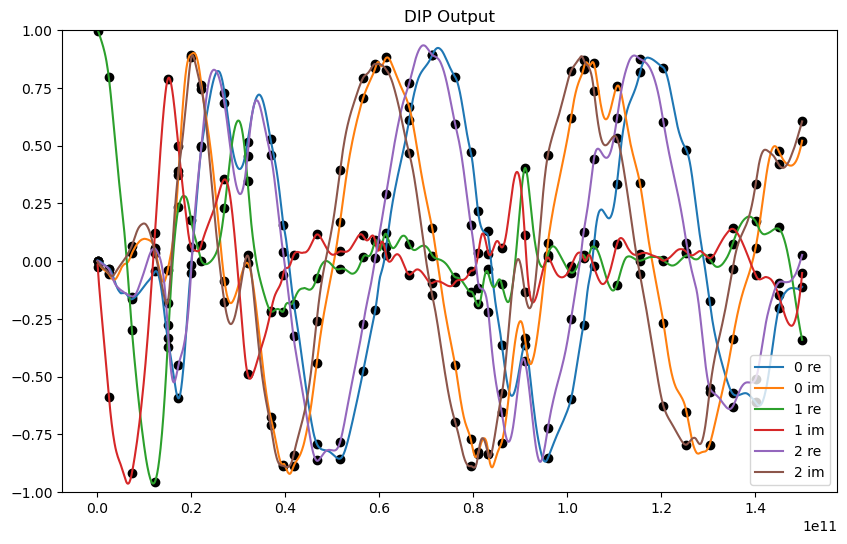

each output:  torch.Size([1, 6, 1500])
after cat:  torch.Size([5, 6, 1500])
after var:  torch.Size([6, 1500])
after sum:  torch.Size([1500])
[   0   24   73  122  149  172  199  221  270  319  368  395  417  466
  516  565  591  614  663  712  761  794  810  831  860  909  958 1007
 1034 1056 1105 1154 1204 1253 1278 1302 1351 1400 1449 1499]
NUM ACTIVELY SAMPLED:  8
DIP PSNR:  34.897763505225335
DIP MSE:  0.0012950414093211293


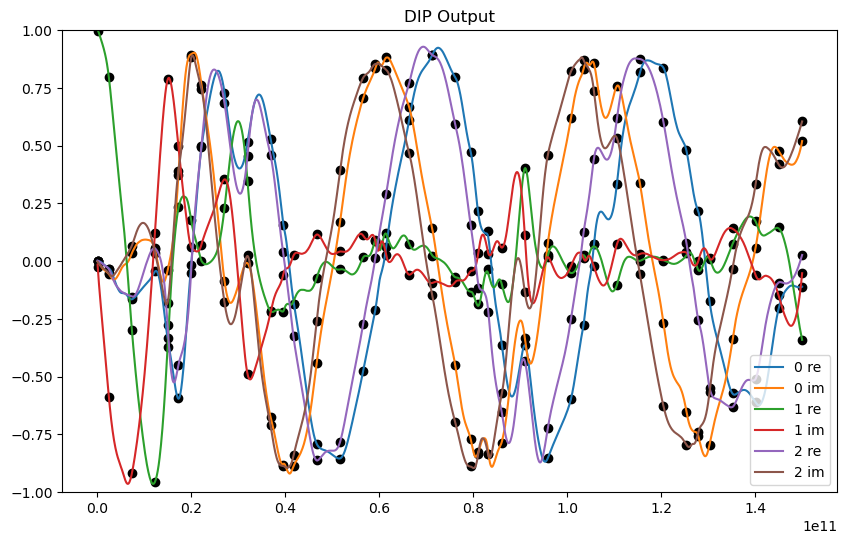

each output:  torch.Size([1, 6, 1500])
after cat:  torch.Size([5, 6, 1500])
after var:  torch.Size([6, 1500])
after sum:  torch.Size([1500])
[   0   24   51   73  122  149  172  199  221  270  319  368  395  417
  466  516  565  591  614  663  712  761  794  810  831  860  909  958
 1007 1034 1056 1105 1154 1204 1253 1278 1302 1351 1400 1449 1499]
NUM ACTIVELY SAMPLED:  9
DIP PSNR:  34.93726419527579
DIP MSE:  0.0012833159416913986


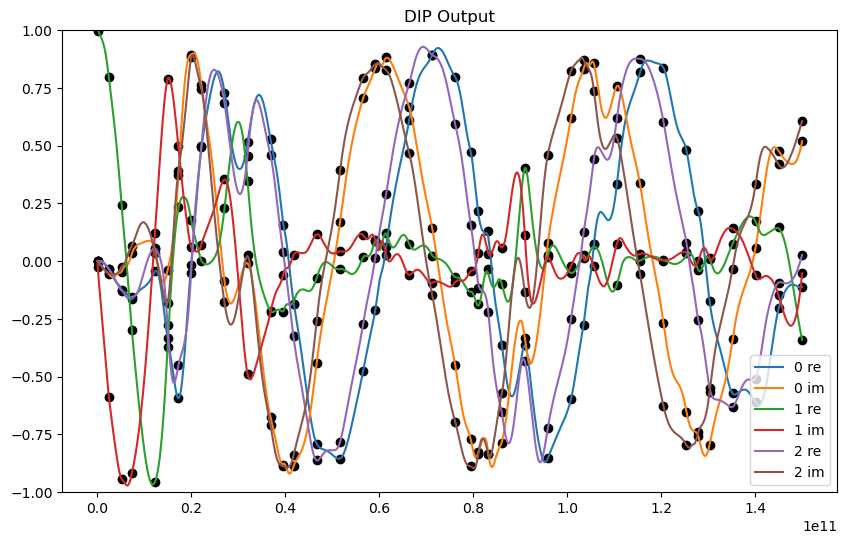

each output:  torch.Size([1, 6, 1500])
after cat:  torch.Size([5, 6, 1500])
after var:  torch.Size([6, 1500])
after sum:  torch.Size([1500])
[   0   24   51   73  122  149  172  199  221  270  319  368  395  417
  466  516  565  591  614  636  663  712  761  794  810  831  860  909
  958 1007 1034 1056 1105 1154 1204 1253 1278 1302 1351 1400 1449 1499]
NUM ACTIVELY SAMPLED:  10
DIP PSNR:  35.11254078226939
DIP MSE:  0.0012325539719313383


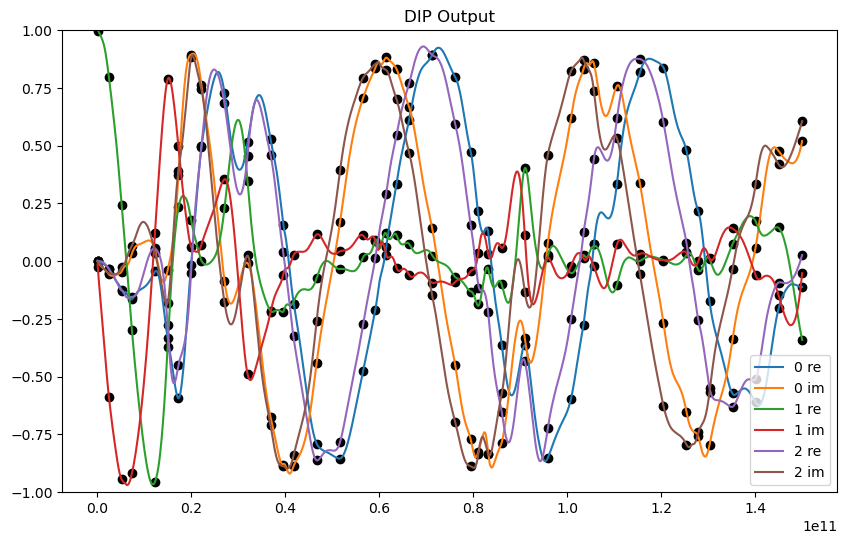

each output:  torch.Size([1, 6, 1500])
after cat:  torch.Size([5, 6, 1500])
after var:  torch.Size([6, 1500])
after sum:  torch.Size([1500])
[   0   24   51   73  122  149  172  199  221  270  319  368  395  417
  466  516  565  591  614  636  663  712  761  794  810  831  860  909
  958 1007 1034 1056 1105 1154 1204 1253 1278 1302 1351 1400 1423 1449
 1499]
NUM ACTIVELY SAMPLED:  11
DIP PSNR:  35.56296290654366
DIP MSE:  0.001111126970499754


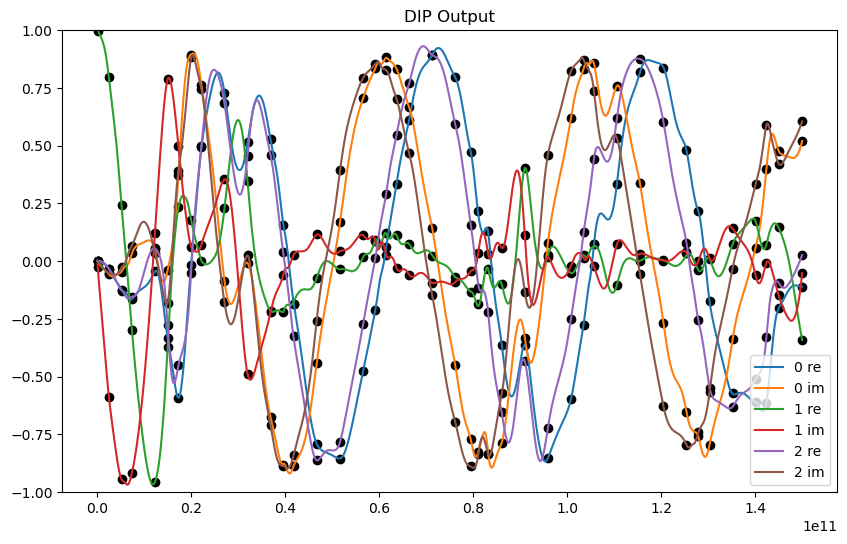

each output:  torch.Size([1, 6, 1500])
after cat:  torch.Size([5, 6, 1500])
after var:  torch.Size([6, 1500])
after sum:  torch.Size([1500])
[   0   24   51   73  122  149  172  199  221  270  319  368  395  417
  466  516  565  591  614  636  663  712  761  794  810  831  860  909
  958 1007 1034 1056 1078 1105 1154 1204 1253 1278 1302 1351 1400 1423
 1449 1499]
NUM ACTIVELY SAMPLED:  12
DIP PSNR:  36.191811997833895
DIP MSE:  0.0009613439906388521


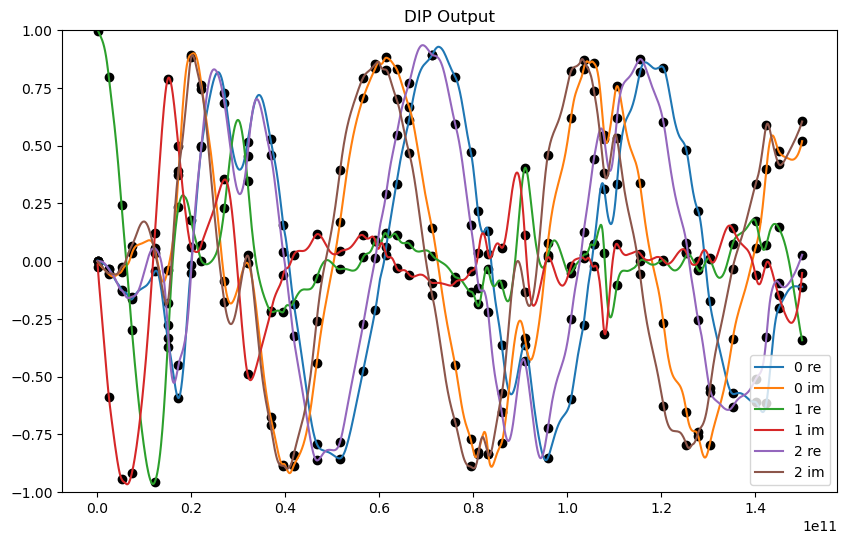

each output:  torch.Size([1, 6, 1500])
after cat:  torch.Size([5, 6, 1500])
after var:  torch.Size([6, 1500])
after sum:  torch.Size([1500])
[   0   24   51   73  122  149  172  199  221  270  319  368  395  417
  466  516  565  591  614  636  663  712  761  794  810  831  860  909
  958 1007 1034 1056 1078 1105 1128 1154 1204 1253 1278 1302 1351 1400
 1423 1449 1499]
NUM ACTIVELY SAMPLED:  13
DIP PSNR:  36.46499305902196
DIP MSE:  0.0009027358028106391


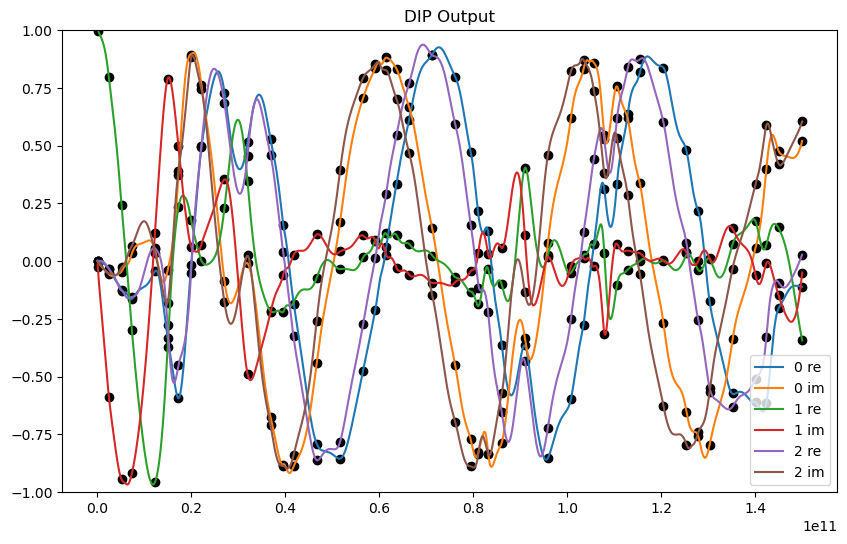

each output:  torch.Size([1, 6, 1500])
after cat:  torch.Size([5, 6, 1500])
after var:  torch.Size([6, 1500])
after sum:  torch.Size([1500])
[   0   24   51   73  122  149  172  199  221  270  319  368  395  417
  466  516  565  591  614  636  663  712  761  794  810  822  831  860
  909  958 1007 1034 1056 1078 1105 1128 1154 1204 1253 1278 1302 1351
 1400 1423 1449 1499]
NUM ACTIVELY SAMPLED:  14
DIP PSNR:  36.361135478793
DIP MSE:  0.000924584164749831


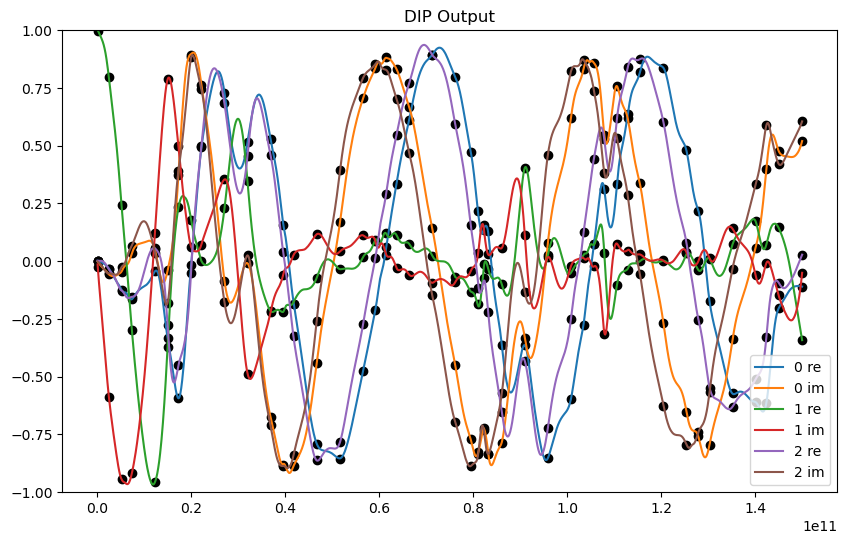

each output:  torch.Size([1, 6, 1500])
after cat:  torch.Size([5, 6, 1500])
after var:  torch.Size([6, 1500])
after sum:  torch.Size([1500])
[   0   24   51   73  122  149  172  199  221  270  319  344  368  395
  417  466  516  565  591  614  636  663  712  761  794  810  822  831
  860  909  958 1007 1034 1056 1078 1105 1128 1154 1204 1253 1278 1302
 1351 1400 1423 1449 1499]
NUM ACTIVELY SAMPLED:  15
DIP PSNR:  36.48030015017507
DIP MSE:  0.0008995596435852349


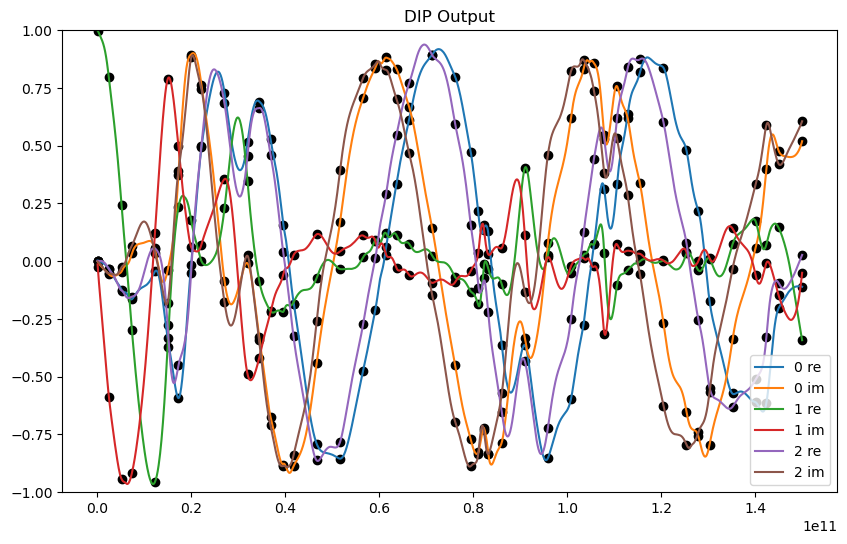

each output:  torch.Size([1, 6, 1500])
after cat:  torch.Size([5, 6, 1500])
after var:  torch.Size([6, 1500])
after sum:  torch.Size([1500])
[   0   24   51   73  122  149  172  187  199  221  270  319  344  368
  395  417  466  516  565  591  614  636  663  712  761  794  810  822
  831  860  909  958 1007 1034 1056 1078 1105 1128 1154 1204 1253 1278
 1302 1351 1400 1423 1449 1499]
NUM ACTIVELY SAMPLED:  16
DIP PSNR:  36.59930428796522
DIP MSE:  0.0008752447902224958


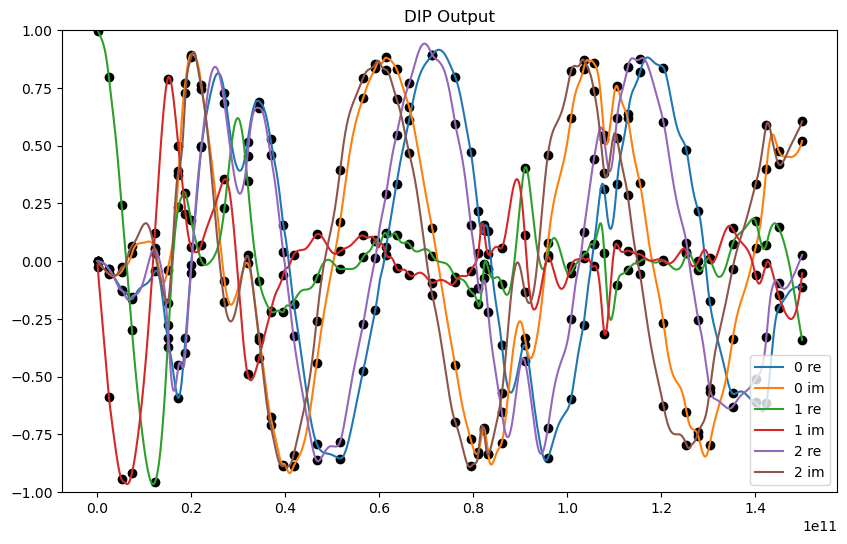

each output:  torch.Size([1, 6, 1500])
after cat:  torch.Size([5, 6, 1500])
after var:  torch.Size([6, 1500])
after sum:  torch.Size([1500])
[   0   24   51   73  122  149  172  187  199  221  270  319  344  368
  395  417  466  516  565  591  602  614  636  663  712  761  794  810
  822  831  860  909  958 1007 1034 1056 1078 1105 1128 1154 1204 1253
 1278 1302 1351 1400 1423 1449 1499]
NUM ACTIVELY SAMPLED:  17
DIP PSNR:  36.612700063764805
DIP MSE:  0.0008725493680685759


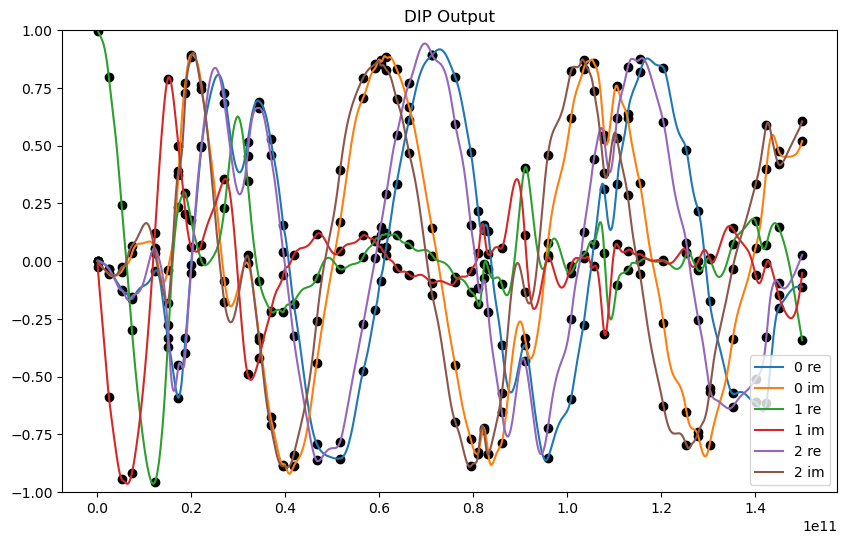

each output:  torch.Size([1, 6, 1500])
after cat:  torch.Size([5, 6, 1500])
after var:  torch.Size([6, 1500])
after sum:  torch.Size([1500])
[   0   24   51   73  122  149  172  187  199  221  270  319  344  368
  395  417  466  516  565  591  602  614  636  663  712  761  794  810
  822  831  860  909  958 1007 1034 1046 1056 1078 1105 1128 1154 1204
 1253 1278 1302 1351 1400 1423 1449 1499]
NUM ACTIVELY SAMPLED:  18
DIP PSNR:  36.67828373527687
DIP MSE:  0.0008594717364758253


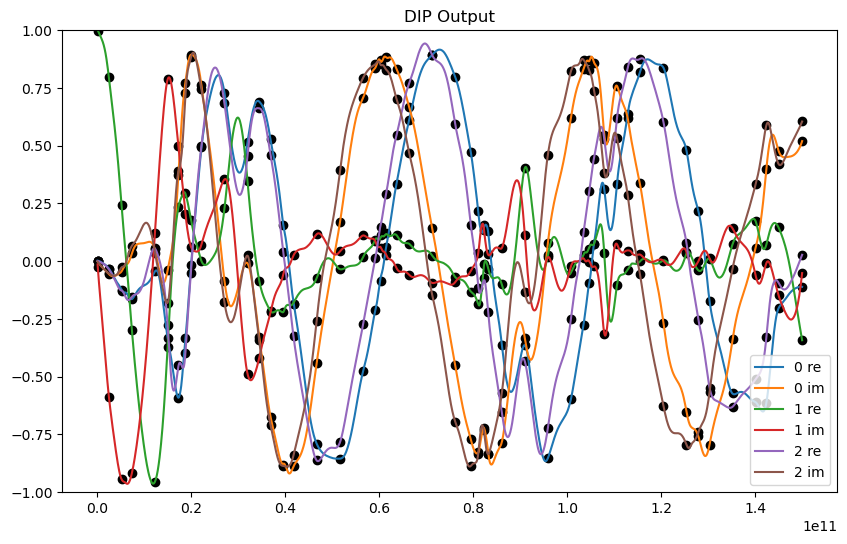

each output:  torch.Size([1, 6, 1500])
after cat:  torch.Size([5, 6, 1500])
after var:  torch.Size([6, 1500])
after sum:  torch.Size([1500])
[   0   24   51   73  122  149  172  187  199  221  270  319  344  368
  395  417  466  516  565  591  602  614  636  663  712  761  794  810
  822  831  860  909  958 1007 1034 1046 1056 1078 1105 1128 1154 1204
 1253 1278 1302 1351 1400 1423 1449 1478 1499]
NUM ACTIVELY SAMPLED:  19
DIP PSNR:  37.2162384438815
DIP MSE:  0.0007593397749587893


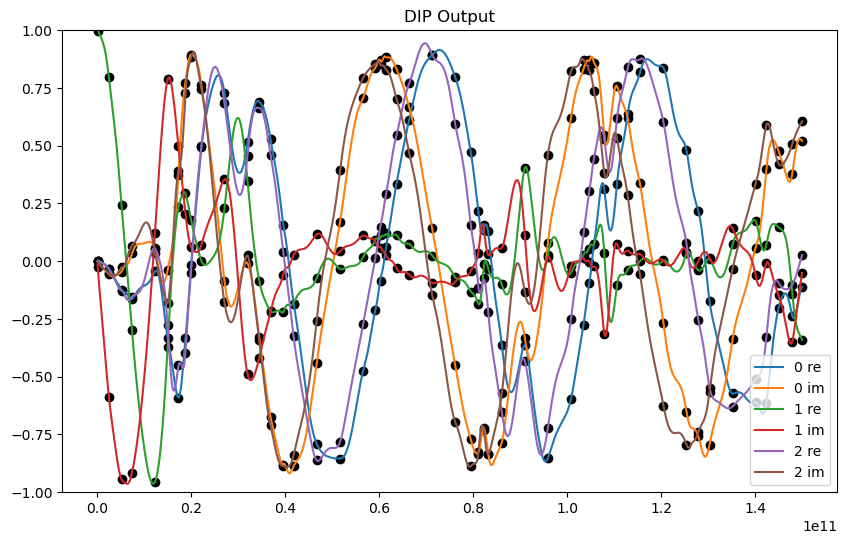

each output:  torch.Size([1, 6, 1500])
after cat:  torch.Size([5, 6, 1500])
after var:  torch.Size([6, 1500])
after sum:  torch.Size([1500])
[   0   24   51   73  122  149  172  187  199  221  270  319  344  368
  395  417  439  466  516  565  591  602  614  636  663  712  761  794
  810  822  831  860  909  958 1007 1034 1046 1056 1078 1105 1128 1154
 1204 1253 1278 1302 1351 1400 1423 1449 1478 1499]
NUM ACTIVELY SAMPLED:  20
DIP PSNR:  37.30471945302988
DIP MSE:  0.0007440258632414043


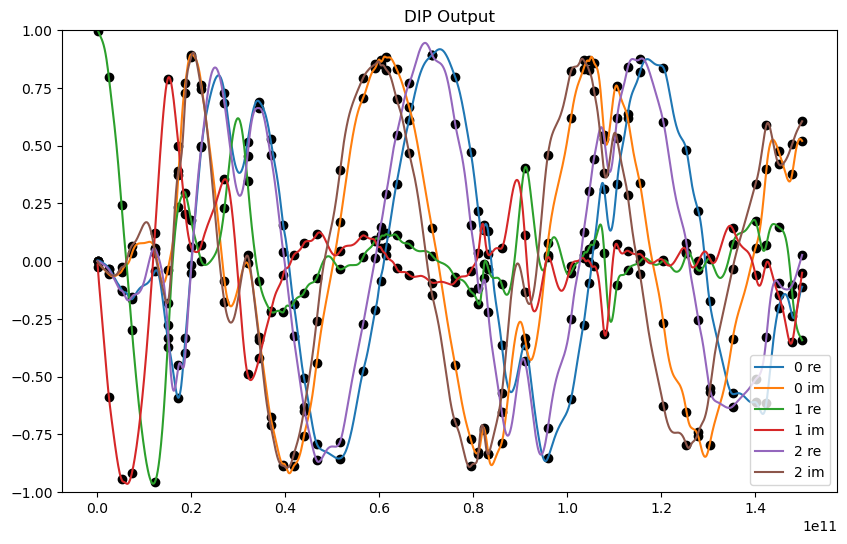

each output:  torch.Size([1, 6, 1500])
after cat:  torch.Size([5, 6, 1500])
after var:  torch.Size([6, 1500])
after sum:  torch.Size([1500])
[   0   24   51   73  122  149  172  187  199  221  270  319  344  368
  395  417  439  466  516  565  591  602  614  636  663  712  761  794
  810  822  831  860  909  929  958 1007 1034 1046 1056 1078 1105 1128
 1154 1204 1253 1278 1302 1351 1400 1423 1449 1478 1499]
NUM ACTIVELY SAMPLED:  21
DIP PSNR:  38.51344656028746
DIP MSE:  0.0005632683751173317


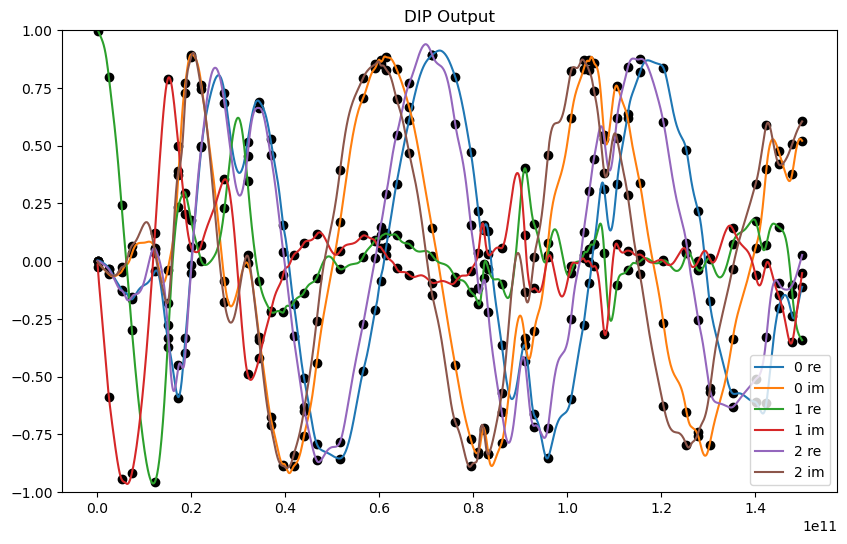

each output:  torch.Size([1, 6, 1500])
after cat:  torch.Size([5, 6, 1500])
after var:  torch.Size([6, 1500])
after sum:  torch.Size([1500])
[   0   24   51   73  122  149  172  187  199  221  270  319  344  368
  395  417  439  466  516  565  591  602  614  636  663  712  761  794
  810  822  831  860  909  929  958  984 1007 1034 1046 1056 1078 1105
 1128 1154 1204 1253 1278 1302 1351 1400 1423 1449 1478 1499]
NUM ACTIVELY SAMPLED:  22
DIP PSNR:  38.40289120290272
DIP MSE:  0.0005777911865152419


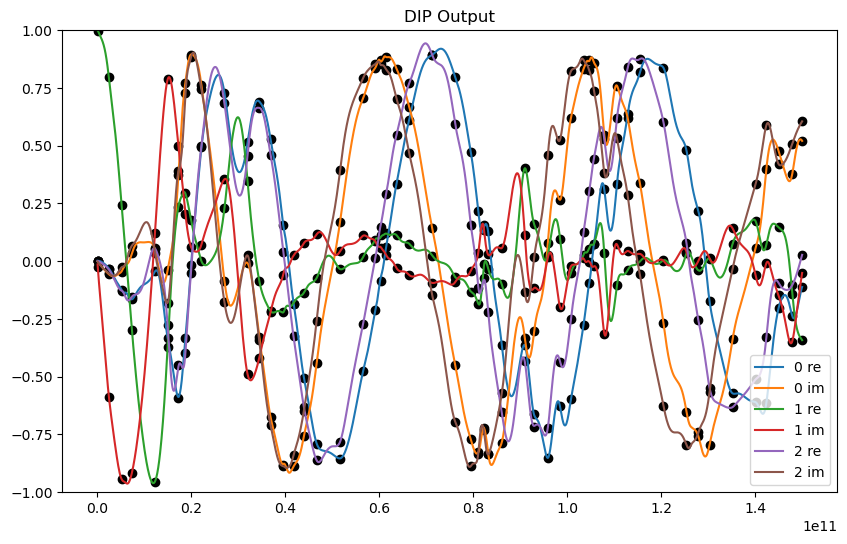

each output:  torch.Size([1, 6, 1500])
after cat:  torch.Size([5, 6, 1500])
after var:  torch.Size([6, 1500])
after sum:  torch.Size([1500])
[   0   24   51   73  122  149  172  187  199  221  270  319  344  368
  395  405  417  439  466  516  565  591  602  614  636  663  712  761
  794  810  822  831  860  909  929  958  984 1007 1034 1046 1056 1078
 1105 1128 1154 1204 1253 1278 1302 1351 1400 1423 1449 1478 1499]
NUM ACTIVELY SAMPLED:  23
DIP PSNR:  38.43053923128583
DIP MSE:  0.0005741244531236589


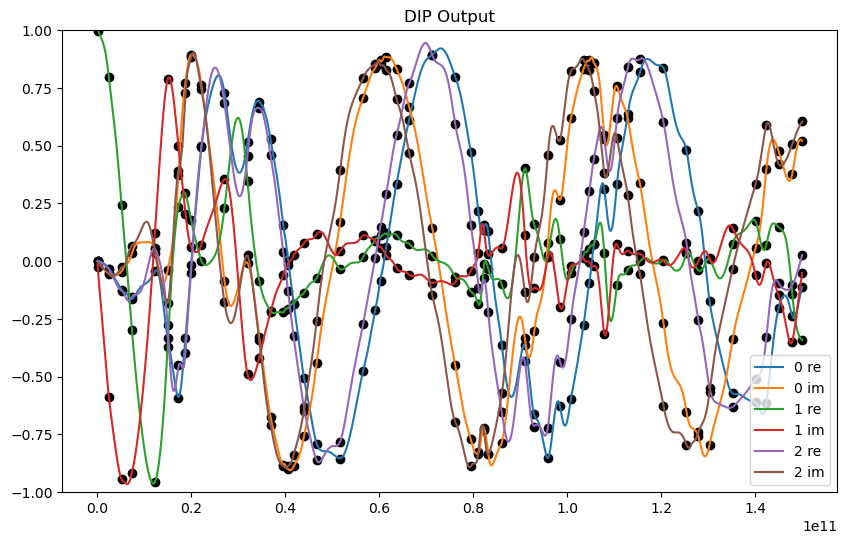

each output:  torch.Size([1, 6, 1500])
after cat:  torch.Size([5, 6, 1500])
after var:  torch.Size([6, 1500])
after sum:  torch.Size([1500])
[   0   24   51   73  122  149  172  187  199  221  270  319  344  368
  395  405  417  439  466  516  565  591  602  614  636  663  712  761
  794  810  819  822  831  860  909  929  958  984 1007 1034 1046 1056
 1078 1105 1128 1154 1204 1253 1278 1302 1351 1400 1423 1449 1478 1499]
NUM ACTIVELY SAMPLED:  24
DIP PSNR:  38.34201761708603
DIP MSE:  0.0005859468365088105


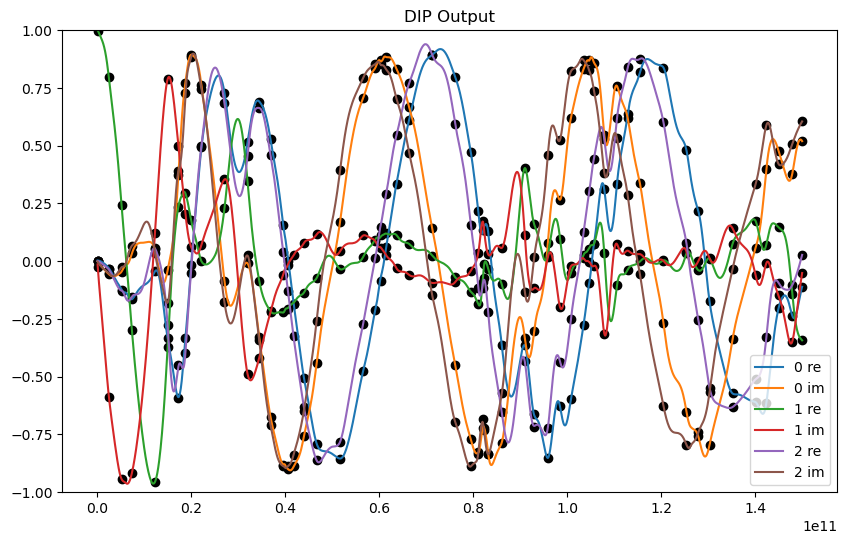

each output:  torch.Size([1, 6, 1500])
after cat:  torch.Size([5, 6, 1500])
after var:  torch.Size([6, 1500])
after sum:  torch.Size([1500])
[   0   24   51   73  122  149  172  187  199  221  270  298  319  344
  368  395  405  417  439  466  516  565  591  602  614  636  663  712
  761  794  810  819  822  831  860  909  929  958  984 1007 1034 1046
 1056 1078 1105 1128 1154 1204 1253 1278 1302 1351 1400 1423 1449 1478
 1499]
NUM ACTIVELY SAMPLED:  25
DIP PSNR:  38.46104390797559
DIP MSE:  0.0005701059708371758


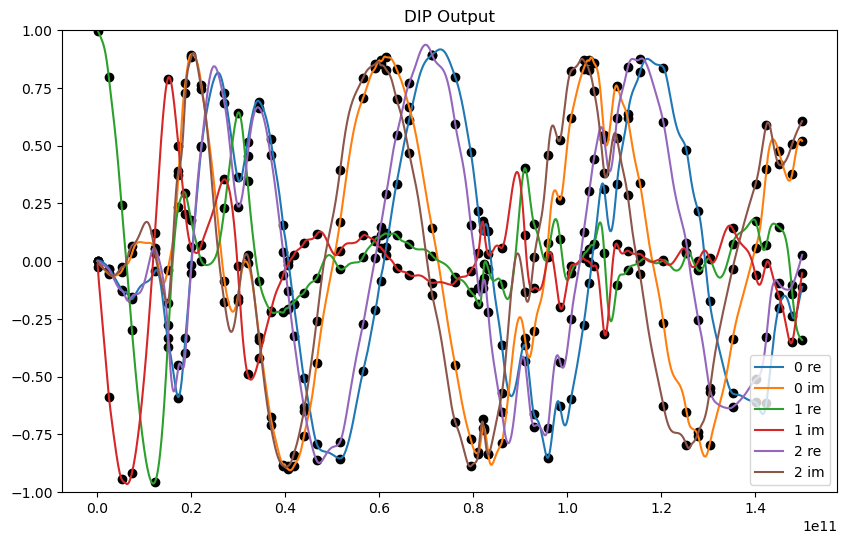

each output:  torch.Size([1, 6, 1500])
after cat:  torch.Size([5, 6, 1500])
after var:  torch.Size([6, 1500])
after sum:  torch.Size([1500])
[   0   24   51   73  122  149  172  187  199  221  270  298  319  344
  368  395  405  417  439  466  516  565  591  602  614  636  663  712
  761  794  810  815  819  822  831  860  909  929  958  984 1007 1034
 1046 1056 1078 1105 1128 1154 1204 1253 1278 1302 1351 1400 1423 1449
 1478 1499]
NUM ACTIVELY SAMPLED:  26
DIP PSNR:  38.51184660346317
DIP MSE:  0.0005634758854284883


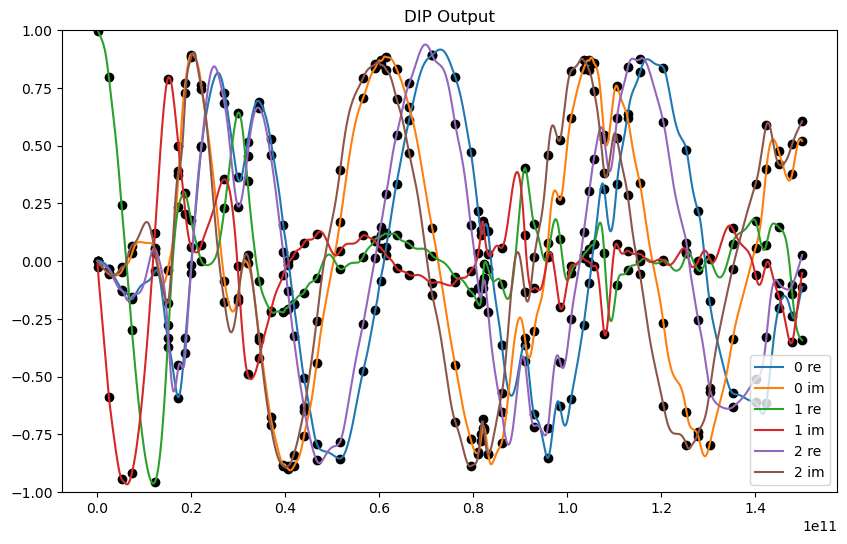

each output:  torch.Size([1, 6, 1500])
after cat:  torch.Size([5, 6, 1500])
after var:  torch.Size([6, 1500])
after sum:  torch.Size([1500])
[   0   24   51   73  122  149  172  187  199  221  270  298  319  344
  368  395  405  417  439  466  516  565  591  602  614  636  663  712
  761  794  810  815  819  822  831  860  885  909  929  958  984 1007
 1034 1046 1056 1078 1105 1128 1154 1204 1253 1278 1302 1351 1400 1423
 1449 1478 1499]
NUM ACTIVELY SAMPLED:  27
DIP PSNR:  39.859300109674244
DIP MSE:  0.0004131711320951581


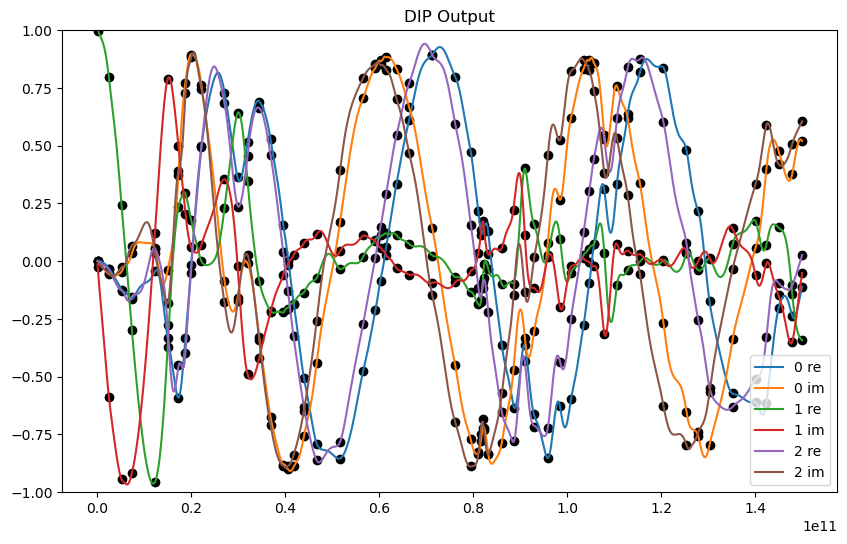

each output:  torch.Size([1, 6, 1500])
after cat:  torch.Size([5, 6, 1500])
after var:  torch.Size([6, 1500])
after sum:  torch.Size([1500])
[   0   24   51   73  122  149  172  187  199  221  270  298  319  344
  368  395  405  417  439  466  516  565  591  602  614  636  663  712
  761  794  810  815  819  822  831  860  885  909  929  958  984 1007
 1034 1046 1056 1078 1105 1128 1154 1204 1253 1264 1278 1302 1351 1400
 1423 1449 1478 1499]
NUM ACTIVELY SAMPLED:  28
DIP PSNR:  39.78599188663931
DIP MSE:  0.000420204596593976


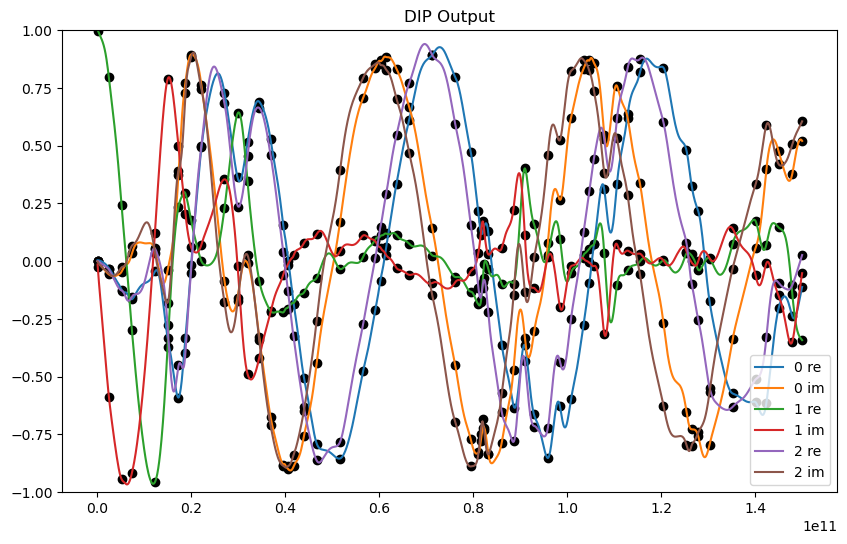

each output:  torch.Size([1, 6, 1500])
after cat:  torch.Size([5, 6, 1500])
after var:  torch.Size([6, 1500])
after sum:  torch.Size([1500])
[   0   24   51   73  122  149  172  187  199  221  270  298  319  344
  368  395  405  417  439  466  492  516  565  591  602  614  636  663
  712  761  794  810  815  819  822  831  860  885  909  929  958  984
 1007 1034 1046 1056 1078 1105 1128 1154 1204 1253 1264 1278 1302 1351
 1400 1423 1449 1478 1499]
NUM ACTIVELY SAMPLED:  29
DIP PSNR:  39.9512378547019
DIP MSE:  0.00040451649692840874


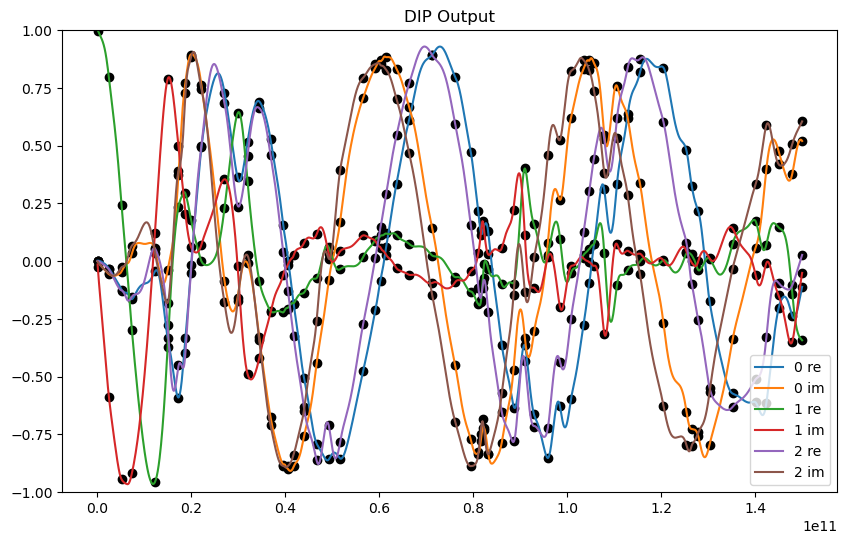

each output:  torch.Size([1, 6, 1500])
after cat:  torch.Size([5, 6, 1500])
after var:  torch.Size([6, 1500])
after sum:  torch.Size([1500])
[   0   24   51   73  122  149  172  187  199  221  270  298  319  344
  368  395  405  417  439  466  492  516  565  591  602  614  636  663
  712  761  794  810  815  819  822  831  860  885  909  929  958  984
 1007 1034 1046 1056 1078 1105 1128 1154 1204 1228 1253 1264 1278 1302
 1351 1400 1423 1449 1478 1499]
NUM ACTIVELY SAMPLED:  30
DIP PSNR:  40.04161958576701
DIP MSE:  0.0003961850015912205


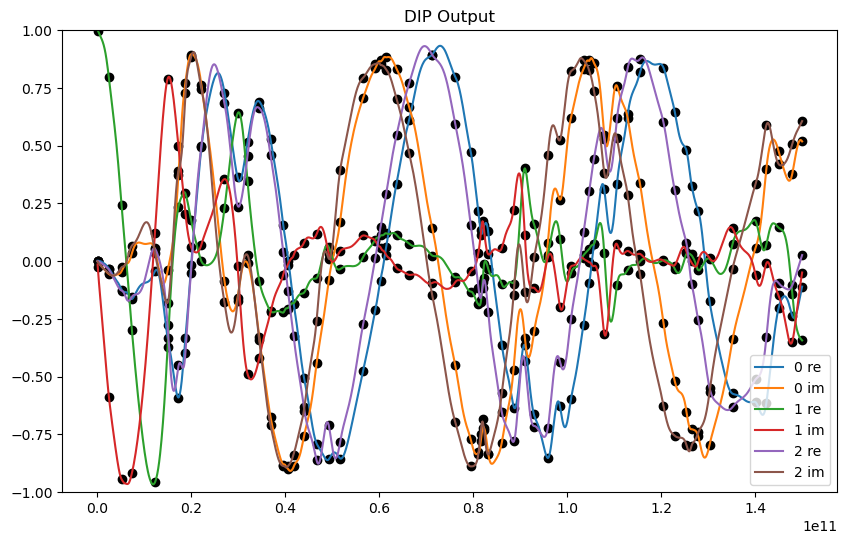

In [101]:
#grab the correct file we want for VF
NUM_ACTIVE = M - len(kept_inds)

LR = 2e-4
FIRST_ITER = 20000
NUM_ITER = 2000
TOTAL_ITERS = FIRST_ITER + NUM_ITER * NUM_ACTIVE

REG_HYPERPARAM = 1.0
NOISY_INPUT = True

if REG_HYPERPARAM > 0:
    regularizer = utils.Smoothing_Loss(per_param=False, reduction="sum")
    regularizer = regularizer.to(device)

optims = [torch.optim.Adam(ensemble[i].parameters(), lr=LR) for i in range(ENSEMBLE_SIZE)]
        
START_NOISE_LEVEL = 1.0
END_NOISE_LEVEL = 0.001
NOISE_DECAY_FACTOR = (END_NOISE_LEVEL / START_NOISE_LEVEL)**(1 / TOTAL_ITERS)
CUR_NOISE_LEVELS = [START_NOISE_LEVEL for i in range(ENSEMBLE_SIZE)]

ensemble_outputs = [None for i in range(ENSEMBLE_SIZE)]
ensemble_all_outputs = [[] for i in range(ENSEMBLE_SIZE)]
ensemble_train_losses = [[] for i in range(ENSEMBLE_SIZE)]
ensemble_train_errors = [[] for i in range(ENSEMBLE_SIZE)]
ensemble_train_regs = [[] for i in range(ENSEMBLE_SIZE)]
ensemble_test_mses = [[] for i in range(ENSEMBLE_SIZE)]
ensemble_test_maes = [[] for i in range(ENSEMBLE_SIZE)]

is_initial_fit = True
tic = time.time()
net.train()
print("NUM ACTIVE: ", NUM_ACTIVE)

CURR_ITER = FIRST_ITER

for num_actively_sampled in range(NUM_ACTIVE + 1):

    if not is_initial_fit:

        # Find the maximum standard deviation point, and use it to update kept_inds
        max_disagree_idx = find_max_variance(ensemble_outputs, pickRandom=False)
        kept_inds = np.sort(np.append(kept_inds, max_disagree_idx))
        print(kept_inds)

        # Recreate the y data with the new kept_inds
        y = torch.clone(x)[:, :, kept_inds]
        y_freqs = gt_freqs[kept_inds]

    for j, net in enumerate(ensemble):

        net.train()

        # Update the criterion to reflect the new point we have sampled
        criterion = utils.Measurement_MSE_Loss(kept_inds=kept_inds, per_param=False, reduction="sum")
        criterion = criterion.to(device)
        optim = optims[j]
        train_losses = []
        train_errors = []
        train_regs = []
        test_mses = []
        test_maes = []

        for i in range(int(CURR_ITER)):
            optim.zero_grad()
            
            if NOISY_INPUT:
                out = net.forward_with_z(CUR_NOISE_LEVELS[j])
                CUR_NOISE_LEVELS[j] *= NOISE_DECAY_FACTOR
            else:
                out = net.forward_with_z()
            
            train_error = criterion(out, y) 
            if REG_HYPERPARAM > 0:
                train_reg = REG_HYPERPARAM * regularizer(out)
                train_loss = train_error + train_reg
            else:
                train_loss = train_error
            
            train_loss.backward()
            optim.step()

            with torch.no_grad():
                
                # Log the standard metrics across different numbers of samples given
                train_losses.append(train_loss.item())
                train_errors.append(train_error.item())
                if REG_HYPERPARAM > 0:
                    train_regs.append(train_reg.item())
                
                test_mse = nn.MSELoss()(out, x)
                test_mses.append(test_mse.item())
                
                test_mae = nn.L1Loss()(out, x)
                test_maes.append(test_mae.item())

                if (i+1)%1000 == 0 or i == 0:
                    toc = time.time()
                    # print("ensemble idx: ", j)
                    # print("ITER ", str(i))
                    # print("TIME: ", str(toc - tic))
                    if NOISY_INPUT:
                        pass
                        # print("NOISE LEVEL: ", CUR_NOISE_LEVELS[j])
                    # print()

        ensemble_outputs[j] = out
        ensemble_all_outputs[j].append(out)
        ensemble_train_losses[j].append(train_losses)
        ensemble_train_errors[j].append(train_errors)
        ensemble_train_regs[j].append(train_regs)
        ensemble_test_mses[j].append(test_mses)
        ensemble_test_maes[j].append(test_maes)

    if is_initial_fit :
        CURR_ITER = NUM_ITER
        is_initial_fit = False

    out = torch.mean(torch.stack(ensemble_outputs), dim=0)

    DIP_OUT_MATRIX = utils.sparams_to_matrix(out)
    DIP_net = utils.matrix_to_network(DIP_OUT_MATRIX, gt_freqs, "DIP Recon With "+str(M)+" Samples for Chip "+str(CHIP_NUM))
    DIP_FINAL_OUT = np.stack((DIP_net.s.real, DIP_net.s.imag), axis=-1)

    dip_data = utils.matrix_to_sparams(DIP_FINAL_OUT)
    psnr_ours = psnr(gt_data, dip_data)

    print("NUM ACTIVELY SAMPLED: ", num_actively_sampled)
    print("DIP PSNR: ", psnr_ours)
    print("DIP MSE: ", nn.MSELoss()(out, x).item())
    plt.figure(figsize=(10,6))
    for i in range(N_SPARAMS):
        
        plt.plot(gt_freqs, out[0,2*i].detach().cpu(), label=str(i)+" re")
        plt.plot(gt_freqs, out[0,2*i+1].detach().cpu(), label=str(i)+" im")

        plt.scatter(gt_freqs[kept_inds], y[0,2*i].cpu(), color='black')
        plt.scatter(gt_freqs[kept_inds], y[0,2*i+1].cpu(), color='black')

        plt.title("DIP Output")
        plt.ylim(-1,1)
        if N_SPARAMS <= 10:
            plt.legend(loc='lower right')
    plt.show()

# print("NUM_SAMPLES ", str(num_actively_sampled))
# print("TIME: ", str(toc - tic))


In [102]:
def bo_stack(list_list_tensor, squeeze=True):
    new_list = []
    for l in list_list_tensor:
        new_list.append(torch.stack(l))
    
    stacked = torch.stack(new_list)
    if squeeze:
        stacked = torch.squeeze(stacked)
    assert len(stacked.shape) == 4 # fuck
    return stacked

In [103]:
ensemble_outputs_stacked = bo_stack(ensemble_all_outputs)
# print(len(ensemble_train_losses[0][0]))
# print(len(ensemble_train_losses[-1]))
# train_losses = np.mean(ensemble_train_losses, axis=0).flatten()
# train_losses = np.concatenate(ensemble_train_losses)

train_losses_list = []
train_errors_list = []
test_maes_list = []
test_mses_list = []
for i in range(ENSEMBLE_SIZE):
    # print(len(ensemble_train_losses[i]))
    concat_list_losses = []
    concat_list_errors = []
    concat_list_maes = []
    concat_list_mses = []
    for j in range(len(ensemble_train_losses[i])):
        concat_list_losses.extend(ensemble_train_losses[i][j])
        concat_list_errors.extend(ensemble_train_errors[i][j])
        concat_list_maes.extend(ensemble_test_maes[i][j])
        concat_list_mses.extend(ensemble_test_mses[i][j])
    train_losses_list.append(concat_list_losses)
    train_errors_list.append(concat_list_errors)
    test_maes_list.append(concat_list_maes)
    test_mses_list.append(concat_list_mses)
train_losses = np.mean(train_losses_list, axis=0)
train_errors = np.mean(train_errors_list, axis=0)
test_maes = np.mean(test_maes_list, axis=0)
test_mses = np.mean(test_mses_list, axis=0)

# train_errors = np.mean(ensemble_train_errors, axis=0).flatten()
# test_maes = np.mean(ensemble_test_maes, axis=0).flatten()
# test_mses = np.mean(ensemble_test_mses, axis=0).flatten()

# Then, get the mean and variance of the actual output shape
# (1, S_PARAMS, FREQS)
out = torch.mean(torch.stack(ensemble_outputs), dim=0)
var_out = torch.var(torch.stack(ensemble_outputs), dim=0)

## Plot metrics and outputs

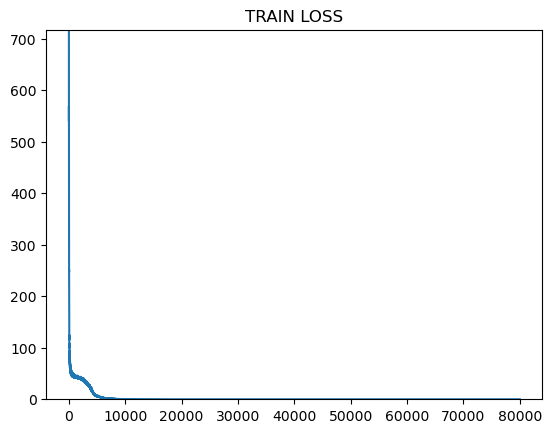

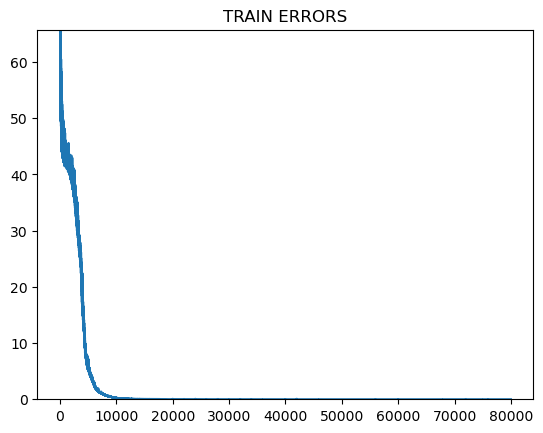

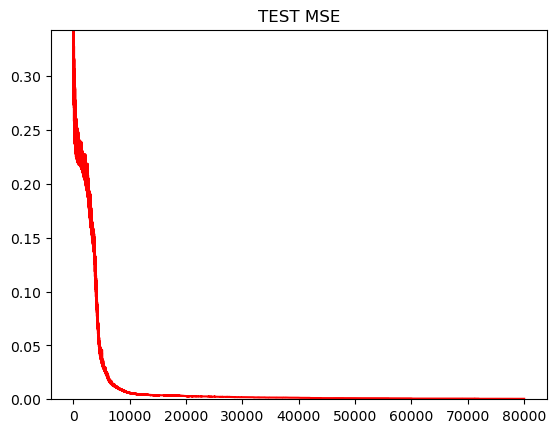

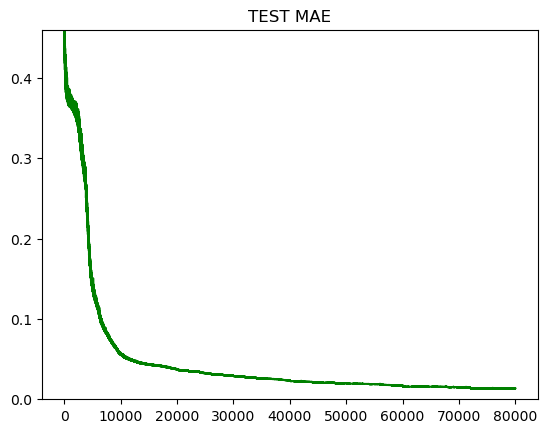

In [104]:
max_idx = 0

plt.figure()
plt.plot(train_losses)
plt.title("TRAIN LOSS")
plt.ylim(0., train_losses[max_idx])
plt.show()

plt.figure()
plt.plot(train_errors)
plt.title("TRAIN ERRORS")
plt.ylim(0., train_errors[max_idx])
plt.show()

plt.figure()
plt.plot(test_mses, color='r')
plt.title("TEST MSE")
plt.ylim(0., test_mses[max_idx])
plt.show()

plt.figure()
plt.plot(test_maes, color='g')
plt.title("TEST MAE")
plt.ylim(0, test_maes[max_idx])
plt.show()

In [105]:
print("Final Test MSE: ", test_mses[-1])
print("Best Test MSE: ", np.min(test_mses))
print("Best Test MSE Iteration: ", np.argmin(test_mses))

Final Test MSE:  0.0004452300549019128
Best Test MSE:  0.0004381591163109988
Best Test MSE Iteration:  78203


In [106]:
# Make the VF Solution and use it as input to network
import VF.vectorfit
import os

LENGTH = len(gt_freqs)

cn = str(CHIP_NUM) if CHIP_NUM > 9 else "0" + str(CHIP_NUM)
fname = os.path.join(ROOT_PATH, "case"+cn)

children = os.listdir(fname)
children = [f for f in children if cn + ".s" in f]

final_path = os.path.join(fname, children[0])

print(final_path)

fitter = VF.vectorfit.VectorFitter(final_path)
print(y_freqs)
fit1 = fitter.vector_fit("VF Result", y_freqs) 
vf_output = fit1.fitted_network.s
print(vf_output.shape)
print(vf_output.dtype)
vf_data = np.stack((vf_output.real, vf_output.imag), axis=-1)
vf_data = utils.matrix_to_sparams(vf_data)
vf_data = torch.tensor(vf_data).view(1, -1, LENGTH)
vf_data = vf_data.to(device)
print(vf_data.shape)

/scratch/cluster/bodeng/UTAFSDataNew/new_data/case20/case20.s2p
[1.000e+08 2.500e+09 5.200e+09 7.400e+09 1.230e+10 1.500e+10 1.730e+10
 1.880e+10 2.000e+10 2.220e+10 2.710e+10 2.990e+10 3.200e+10 3.450e+10
 3.690e+10 3.960e+10 4.060e+10 4.180e+10 4.400e+10 4.670e+10 4.930e+10
 5.170e+10 5.660e+10 5.920e+10 6.030e+10 6.150e+10 6.370e+10 6.640e+10
 7.130e+10 7.620e+10 7.950e+10 8.110e+10 8.160e+10 8.200e+10 8.230e+10
 8.320e+10 8.610e+10 8.860e+10 9.100e+10 9.300e+10 9.590e+10 9.850e+10
 1.008e+11 1.035e+11 1.047e+11 1.057e+11 1.079e+11 1.106e+11 1.129e+11
 1.155e+11 1.205e+11 1.229e+11 1.254e+11 1.265e+11 1.279e+11 1.303e+11
 1.352e+11 1.401e+11 1.424e+11 1.450e+11 1.479e+11 1.500e+11]
Performing fit with 1 poles.
  Fitting took 0.0313721913844347 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
Performing fit with 2 poles.
  Fitting took 0.017837446182966232 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit wi

/u/bodeng/CurveFitting-DIP/unknown_number_samples/../VF/vectorfit.py:227: UserWarning: The fitted network is passive, but the vector fit is not passive. Consider running `passivity_enforce()` to enforce passivity before using this model.
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fitting took 0.04503090679645538 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 6 poles better than 5 (err 0.1240938033184798 vs 0.4397190506864704)
Performing fit with 6 poles.
  Fitting took 0.043948620557785034 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 7 was not subtantially better than 6 (err 0.12778153664621236 vs 0.1240938033184798)
Performing fit with 7 poles.
  Fitting took 0.051586927846074104 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 8 poles better than 6 (err 0.1104081826475569 vs 0.1240938033184798)
Performing fit with 8 poles.
  Fitting took 0.04574260115623474 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 9 was not subtantially better than 8 (err 0.12808219110540983 vs 0.1104081826475569)
Performing fit with 9 poles.
  Fitting took 0.05566891096532345 seconds.
  Fill

/u/bodeng/CurveFitting-DIP/unknown_number_samples/../VF/vectorfit.py:227: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly. 
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fitting took 1.7223822362720966 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 26 was not subtantially better than 25 (err 0.00031819644053290413 vs 0.00039356124652744685)
Performing fit with 26 poles.
  Fitting took 1.4219651333987713 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 28 poles better than 25 (err 0.00016510111257682825 vs 0.00039356124652744685)
Performing fit with 27 poles.
  Fitting took 1.6670119147747755 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 29 was not subtantially better than 28 (err 0.00019011790832870252 vs 0.00016510111257682825)
Performing fit with 28 poles.
  Fitting took 1.6873387228697538 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 30 was not subtantially better than 28 (err 0.00015250570628537937 vs 0.00016510111257682825)
Fit completed in 10.783658981

In [107]:
## Make neworks from DIP, Interp, and Observations
DIP_OUT_MATRIX = utils.sparams_to_matrix(out)
VF_MATRIX = utils.sparams_to_matrix(vf_data)
Y_MATRIX = utils.sparams_to_matrix(y)

print(DIP_OUT_MATRIX.shape)
print(VF_MATRIX.shape)
print(Y_MATRIX.shape)

DIP_net = utils.matrix_to_network(DIP_OUT_MATRIX, gt_freqs, "DIP Recon With "+str(M)+" Samples for Chip "+str(CHIP_NUM))
VF_net = utils.matrix_to_network(VF_MATRIX, gt_freqs, "Vector Fit With "+str(M)+" Samples for Chip "+str(CHIP_NUM))
Y_net = utils.matrix_to_network(Y_MATRIX, y_freqs, "Observations for Chip "+str(CHIP_NUM))

DIP_FINAL_OUT = np.stack((DIP_net.s.real, DIP_net.s.imag), axis=-1)
VF_FINAL_OUT = np.stack((VF_net.s.real, VF_net.s.imag), axis=-1)

print(DIP_FINAL_OUT.shape)
print(VF_FINAL_OUT.shape)

dip_data = utils.matrix_to_sparams(DIP_FINAL_OUT)
vf_data_mat = utils.matrix_to_sparams(VF_FINAL_OUT)

print(dip_data.shape)
print(vf_data_mat.shape)
print(dip_data.dtype)
print(vf_data_mat.dtype)

## Compare DIP, VF, and Interp
import skimage.metrics
from skimage.metrics import peak_signal_noise_ratio as psnr

psnr_ours = psnr(gt_data, dip_data)
psnr_vf = psnr(gt_data, vf_data_mat)
print("DIP PSNR:      ", psnr_ours)
print("VF PSNR:       ", psnr_vf)

print("Final DIP MSE: ", test_mses[-1])
print("VF MSE:        ", nn.MSELoss()(vf_data, x).item())
# print("Mean DIP MSE: ", nn.MSELoss()([-1][np.newaxis], x).item())

torch.Size([1500, 2, 2, 2])
torch.Size([1500, 2, 2, 2])
torch.Size([62, 2, 2, 2])
(1500, 2, 2, 2)
(1500, 2, 2, 2)
(3, 2, 1500)
(3, 2, 1500)
float32
float32
DIP PSNR:       40.04161958576701
VF PSNR:        39.180627039217825
Final DIP MSE:  0.0004452300549019128
VF MSE:         0.00048305580276064575


(1500,)
torch.Size([1, 6, 1500])
torch.Size([1, 6, 62])
torch.Size([1, 6, 1500])
torch.Size([1, 6, 1500])


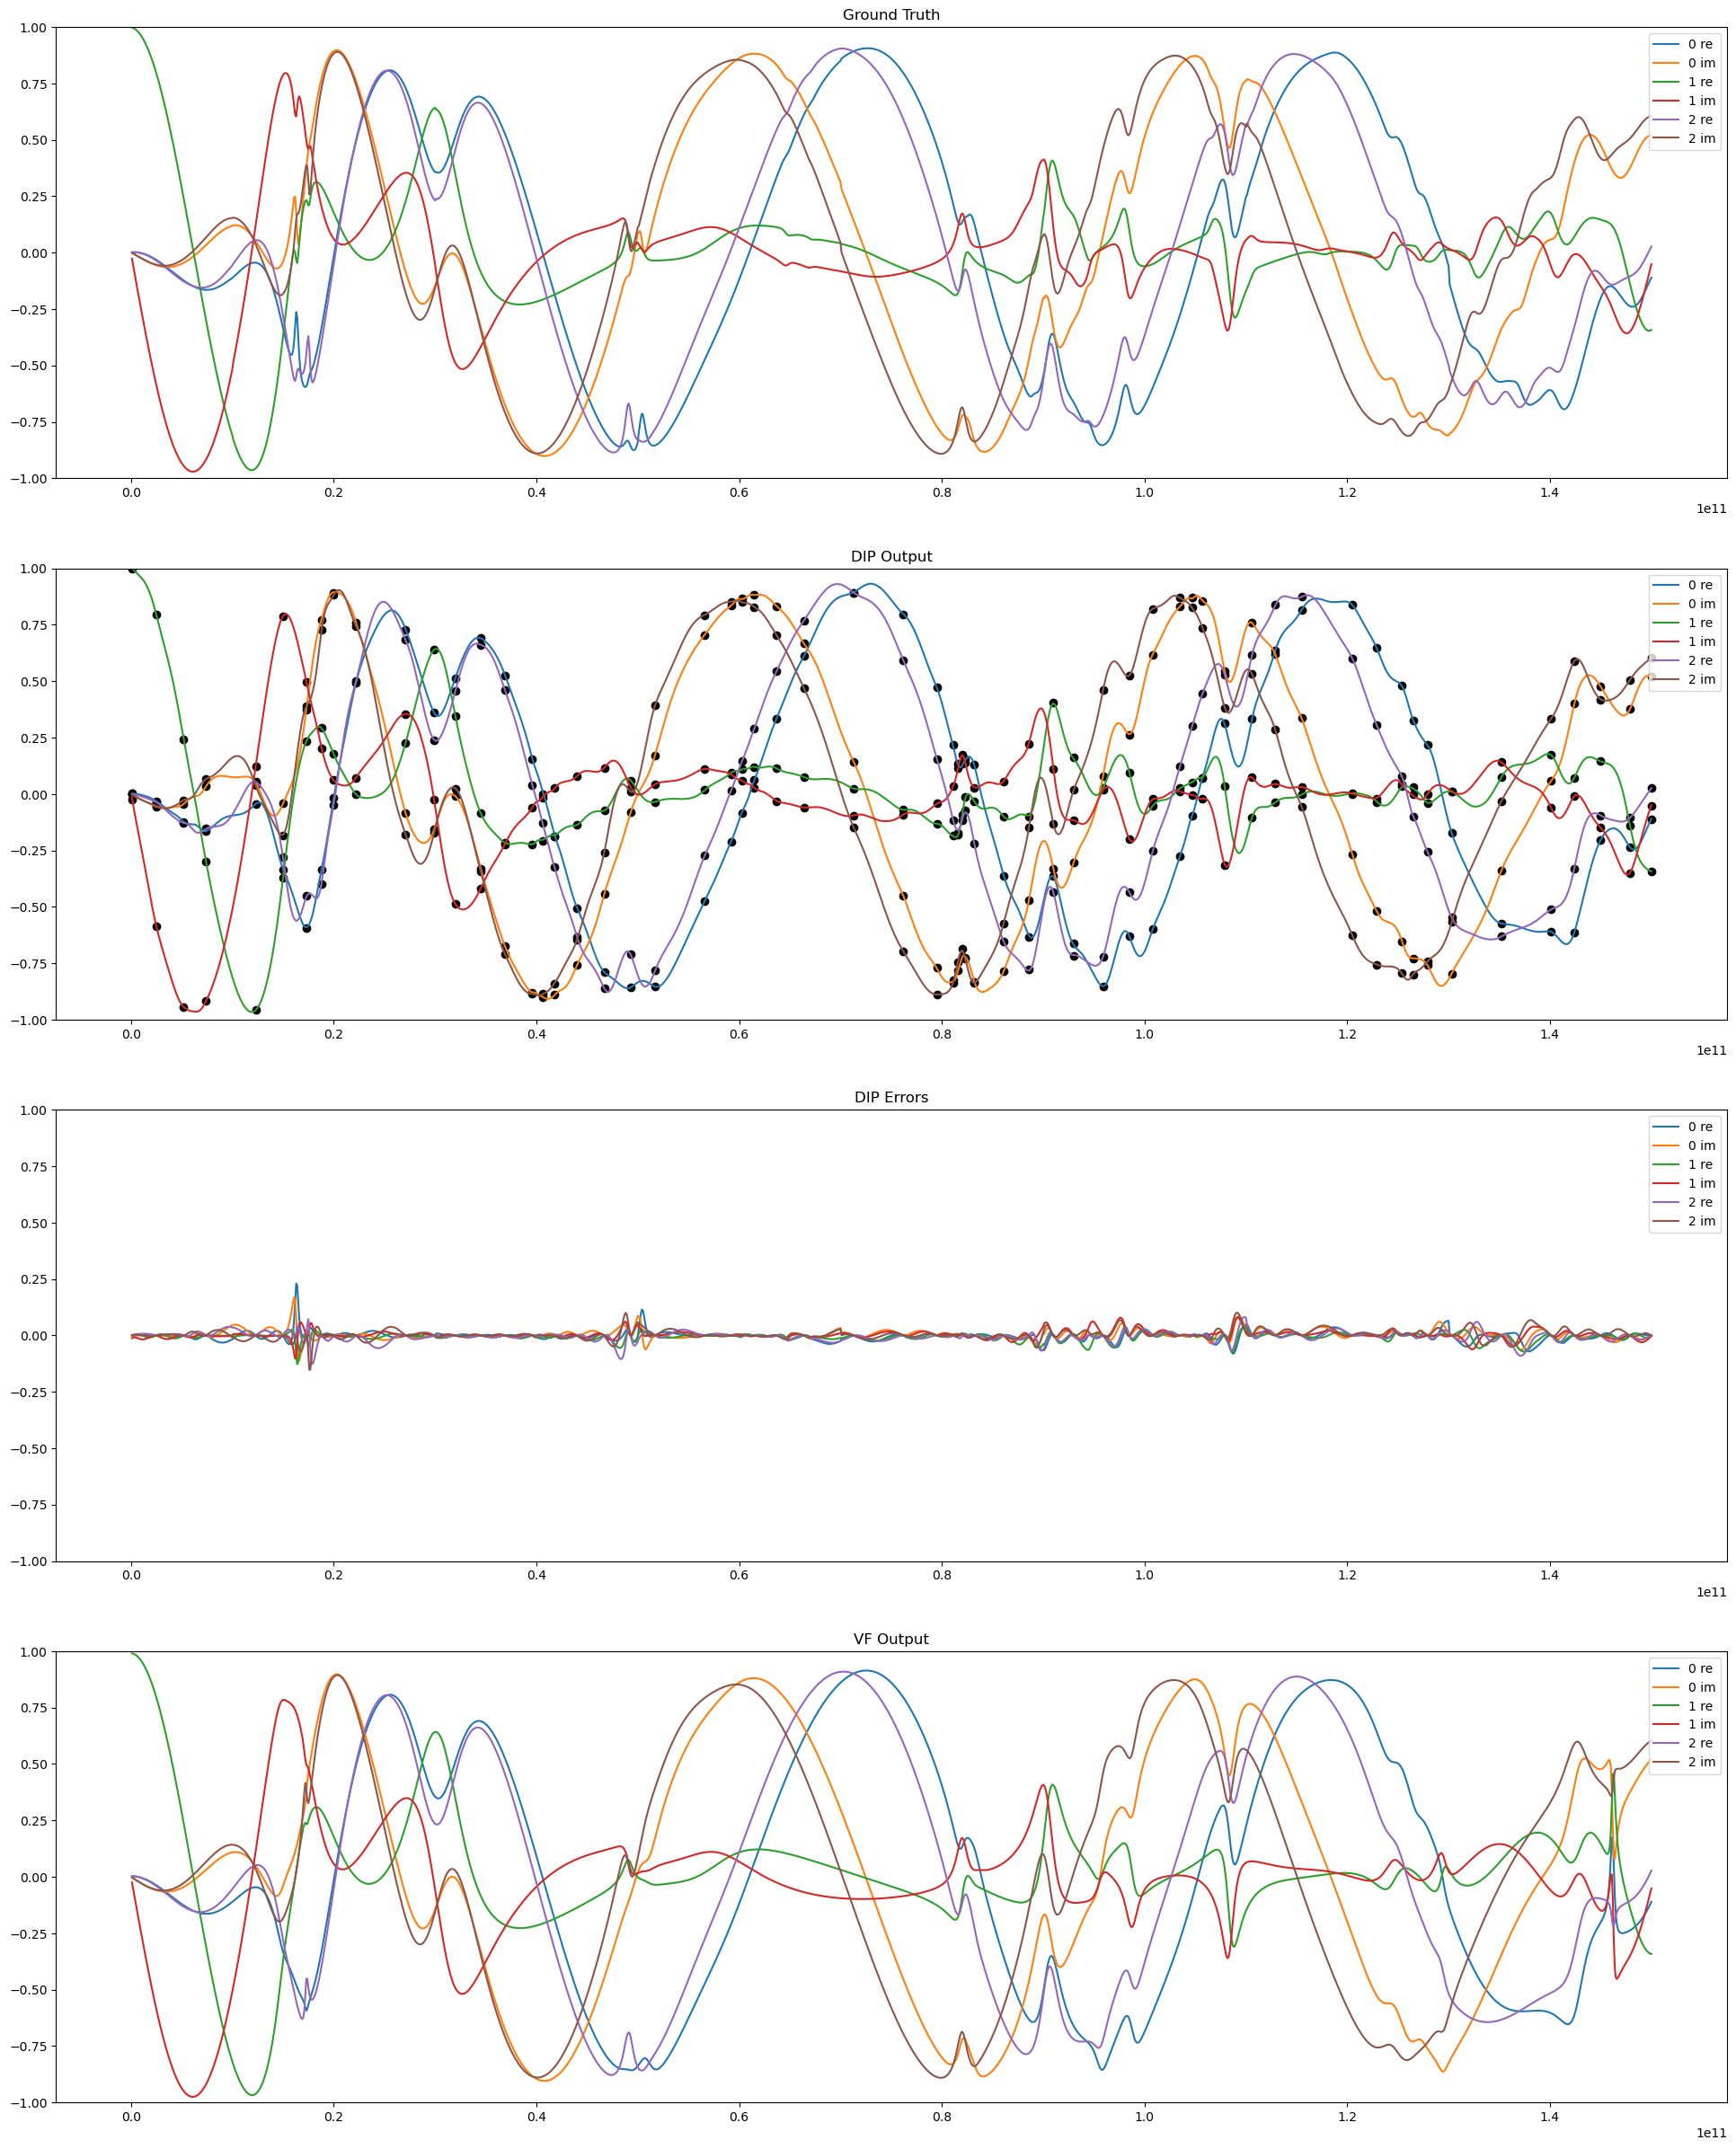

In [108]:
dip_errors = x.detach().cpu() - out.detach().cpu()
print(gt_freqs.shape)
print(dip_errors.shape)
print(y.shape)

print(out.shape)
print(vf_data.shape)

fig, axes = plt.subplots(4,1, figsize=(24, 30))
axes = axes.flatten()

for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" re")
    axes[0].plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" im")
axes[0].set_title("Ground Truth")
axes[0].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[0].legend(loc='upper right')

# SHOW WITH MEAN AND STD DEVS
# for i in range(N_SPARAMS):

#     axes[1].plot(gt_freqs, sgld_means_by_sample[-1][2*i].detach().cpu(), label=str(i)+" re")
#     axes[1].plot(gt_freqs, sgld_means_by_sample[-1][2*i+1].detach().cpu(), label=str(i)+" im")
#     axes[1].fill_between(gt_freqs, sgld_means_by_sample[-1][2*i].detach().cpu() - 2 * sgld_stds_by_sample[-1][2*i].detach().cpu(), sgld_means_by_sample[-1][2*i].detach().cpu() + 2 * sgld_stds_by_sample[-1][2*i].detach().cpu())
#     axes[1].fill_between(gt_freqs, sgld_means_by_sample[-1][2*i+1].detach().cpu() - 2 * sgld_stds_by_sample[-1][2*i+1].detach().cpu(), sgld_means_by_sample[-1][2*i+1].detach().cpu() + 2 * sgld_stds_by_sample[-1][2*i+1].detach().cpu())

#     # axes[1].scatter(gt_freqs[kept_inds], y[0,2*i].cpu(), color='black')
#     # axes[1].scatter(gt_freqs[kept_inds], y[0,2*i+1].cpu(), color='black')


# axes[1].set_title("DIP Output")
# axes[1].set_ylim(-1,1)
# if N_SPARAMS <= 10:
#     axes[1].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, out[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[1].plot(gt_freqs, out[0,2*i+1].detach().cpu(), label=str(i)+" im")

    axes[1].scatter(gt_freqs[kept_inds], y[0,2*i].cpu(), color='black')
    axes[1].scatter(gt_freqs[kept_inds], y[0,2*i+1].cpu(), color='black')

axes[1].set_title("DIP Output")
axes[1].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[1].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[2].plot(gt_freqs, dip_errors[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[2].plot(gt_freqs, dip_errors[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[2].set_title("DIP Errors")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[3].plot(gt_freqs, vf_data[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[3].plot(gt_freqs, vf_data[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[3].set_title("VF Output")
axes[3].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[3].legend(loc='upper right')

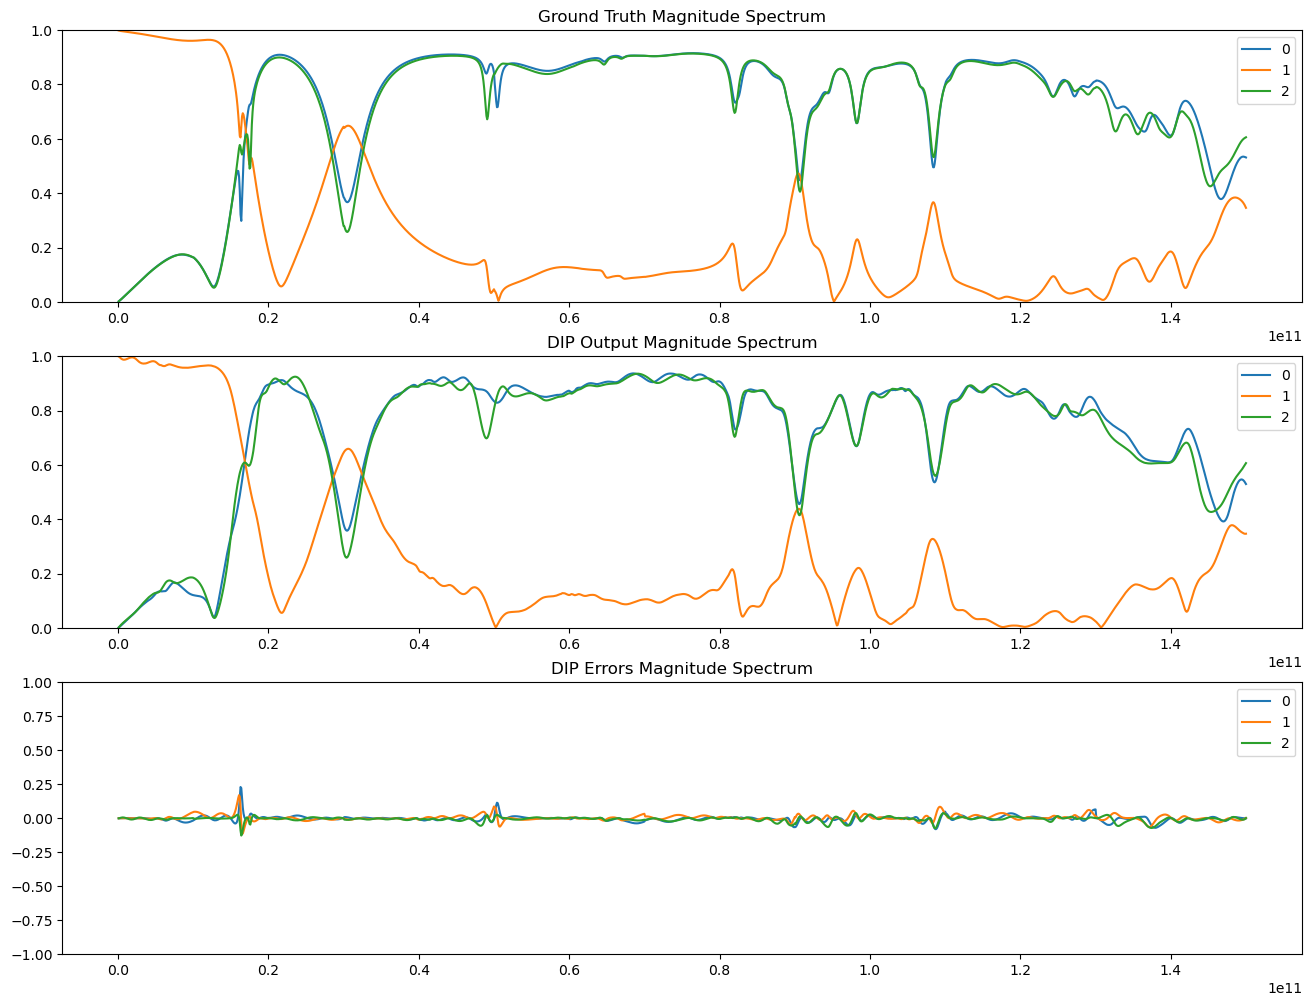

In [109]:
out_mag = utils.sparams_to_mag(out)
dip_errors_mag = x_mag - out_mag 

fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x_mag[0,i].cpu(), label=str(i))
axes[0].set_title("Ground Truth Magnitude Spectrum")
axes[0].set_ylim(0,1)
if N_SPARAMS <= 10:
    axes[0].legend()

for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, out_mag[0,i].detach().cpu(), label=str(i))
axes[1].set_title("DIP Output Magnitude Spectrum")
axes[1].set_ylim(0,1)
if N_SPARAMS <= 10:
    axes[1].legend()
    
for i in range(N_SPARAMS):
    axes[2].plot(gt_freqs, dip_errors[0,i].detach().cpu(), label=str(i))
axes[2].set_title("DIP Errors Magnitude Spectrum")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend()

In [110]:
print(kept_inds)

[   0   24   51   73  122  149  172  187  199  221  270  298  319  344
  368  395  405  417  439  466  492  516  565  591  602  614  636  663
  712  761  794  810  815  819  822  831  860  885  909  929  958  984
 1007 1034 1046 1056 1078 1105 1128 1154 1204 1228 1253 1264 1278 1302
 1351 1400 1423 1449 1478 1499]
